# Master Thesis – Customer Churn Prediction
---
This notebook implements the methodology described in my proposal:

- Dataset: Kaggle Banking Churn (Simronw, 2023) – 5,000 records.
- Goal: Compare ML & DL approaches for churn prediction.
- Key features: leakage-safe preprocessing, stratified splitting, SMOTE/GAN oversampling, Optuna tuning, SHAP interpretability.
- Objectives:
    1. Load libraries and dataset.  
    2. Inspect dataset structure.  
    3. Perform basic EDA – correlation of numeric features with churn.

## Part 1 Loading data and basic EDA


In [2]:
# ==== A. Imports, env, and global flags ====
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

# Reduce thread oversubscription (stability during CV/tuning)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# Version-safe OneHotEncoder keyword (sklearn >= 1.2 uses sparse_output)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
_OHE_KW = {}
try:
    OneHotEncoder(sparse_output=False)
    _OHE_KW = dict(sparse_output=False, handle_unknown="ignore")
except TypeError:
    _OHE_KW = dict(sparse=False, handle_unknown="ignore")

from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)

# imbalanced-learn availability
try:
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

In [3]:

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# settings
pd.set_option("display.max_columns", None)
RANDOM_STATE = 42

# --- Load dataset ---
df = pd.read_csv("customer_churn_dataset.csv")

print("Shape:", df.shape)
df.head()


Shape: (5000, 26)


,Customer_ID,Age,Gender,Account_Type,Account_Balance,Transaction_Date,Transaction_Amount,Transaction_Type,Branch,Loan_Amount,Loan_Type,Credit_Score,Is_Employed,Annual_Income,Marital_Status,Region,Account_Open_Date,Last_Transaction_Date,Number_of_Transactions,Account_Activity_Trend,Customer_Service_Interactions,Recent_Complaints,Change_in_Account_Balance,Customer_Satisfaction_Score,Churn_Label,Churn_Timeframe
0,8f0b813f-971a-45c8-8347-48a0d5cd3f2e,50,Female,Savings,26046.21,2025-02-14,4819.48,Payment,Freemanview,1063.29,Personal,475,False,154965.66,Single,West,2022-08-26,2025-03-24,8,Increasing,1,2,-1024.51,1,1,1
1,ec299825-6aa6-47f3-bfc0-0b65d3d4b1e3,69,Female,Checking,27415.23,2025-02-26,3072.79,Deposit,Floresmouth,35493.90,Home,483,True,187805.23,Widowed,East,2024-06-18,2025-03-02,4,Stable,1,0,-2900.10,3,0,0
2,3f992fba-cd14-417e-b5d9-55173b985bef,38,Female,Checking,86709.64,2025-03-26,1423.93,Deposit,West Francis,0.00,NaN,567,True,59195.91,Married,West,2020-08-17,2025-03-13,2,Increasing,4,0,-2600.01,1,0,0
3,be551680-156f-4f47-b283-192bbcb80571,57,Male,Savings,56826.79,2025-02-25,3929.43,Deposit,Diazport,41939.84,NaN,334,False,161364.43,Single,South,2023-09-15,2025-03-26,18,Stable,0,2,154.73,1,1,11
4,644424a9-3423-4a0a-84bb-d83677e73f98,30,Male,Checking,27586.90,2025-01-21,4241.96,Payment,West Marytown,0.00,NaN,707,False,48553.41,Married,North,2023-12-27,2025-02-28,17,Decreasing,0,1,1608.54,4,0,0


Dataset overview
- One row per customer (n ≈ 5,000).  
- Columns:  
  - **customer_id** (unique ID, to be dropped later).  
  - **Churn** (binary target: 1 = churn, 0 = active).  
  - 5 categorical demographic variables.  
  - Multiple numeric variables (credit score, balances, loan info, transactions, etc.).  
- Appendices A & B define schema and engineered features (to be added later).


In [5]:
# ==== B. Column config & helpers ====
target_col = "Churn_Label"
assert target_col in df.columns, f"Target column '{target_col}' not found"

numeric_features = df.select_dtypes(include=[np.number]).columns.drop([target_col], errors="ignore").tolist()
categorical_features = df.select_dtypes(include=["object","category","bool"]).columns.tolist()

HIGH_CARD_COLS = [c for c in ["Branch", "Region"] if c in df.columns]
categorical_low = [c for c in categorical_features if c not in HIGH_CARD_COLS]

if not numeric_features:
    raise ValueError("No numeric features detected. Check datatypes/engineering.")

In [6]:
# Basic structure and missing values check
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer_ID                    5000 non-null   object 
 1   Age                            5000 non-null   int64  
 2   Gender                         5000 non-null   object 
 3   Account_Type                   5000 non-null   object 
 4   Account_Balance                5000 non-null   float64
 5   Transaction_Date               5000 non-null   object 
 6   Transaction_Amount             5000 non-null   float64
 7   Transaction_Type               5000 non-null   object 
 8   Branch                         5000 non-null   object 
 9   Loan_Amount                    5000 non-null   float64
 10  Loan_Type                      1200 non-null   object 
 11  Credit_Score                   5000 non-null   int64  
 12  Is_Employed                    5000 non-null   b

Customer_ID                         0
Age                                 0
Gender                              0
Account_Type                        0
Account_Balance                     0
Transaction_Date                    0
Transaction_Amount                  0
Transaction_Type                    0
Branch                              0
Loan_Amount                         0
Loan_Type                        3800
Credit_Score                        0
Is_Employed                         0
Annual_Income                       0
Marital_Status                      0
Region                              0
Account_Open_Date                   0
Last_Transaction_Date               0
Number_of_Transactions              0
Account_Activity_Trend              0
Customer_Service_Interactions       0
Recent_Complaints                   0
Change_in_Account_Balance           0
Customer_Satisfaction_Score         0
Churn_Label                         0
Churn_Timeframe                     0
dtype: int64

### 1.1 Ensure target column (`Churn_Label`) is binary numeric
- If it's 'Yes'/'No' or 'Churned'/'Active', we map to 1/0.
- If it's already numeric (0/1), we keep as is.

In [8]:
target_col = "Churn_Label"
assert target_col in df.columns, f"Target column '{target_col}' not found."

# Coerce to numeric 0/1 safely
if not pd.api.types.is_numeric_dtype(df[target_col]):
    # common string encodings
    mapping_candidates = [
        {"Yes":1, "No":0},
        {"Churned":1, "Active":0},
        {"True":1, "False":0},
        {"Y":1, "N":0}
    ]
    col = df[target_col].astype(str).str.strip()
    mapped = None
    for m in mapping_candidates:
        if set(col.unique()).issubset(set(m.keys())):
            mapped = col.map(m)
            break
    if mapped is None:
        # fallback: try to cast; non-numeric -> NaN
        mapped = pd.to_numeric(col, errors="coerce")
    df[target_col] = mapped.fillna(0).astype(int)

print(df[target_col].value_counts(dropna=False))
print("Target dtype:", df[target_col].dtype)

Churn_Label
0    3417
1    1583
Name: count, dtype: int64
Target dtype: int64


### 1.2. Correlation of Numeric Features with Churn_Label
We use **point-biserial correlation** (equivalent to Pearson with a binary target):
- Measures strength & direction of relationship to `Churn_Label`.
- Output: correlation coefficient + p-value.
- Goal: identify which numeric variables contribute most to churn.

In [10]:
from scipy.stats import pointbiserialr 


# Identify numeric columns (excluding ID and target)
id_cols = [c for c in df.columns if c.lower() in ["customer_id", "id", "client_id"]]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in id_cols + [target_col]]

correlations = []
for col in numeric_cols:
    # fillna to avoid dropping rows; use median for safety in EDA
    x = df[col].fillna(df[col].median())
    y = df[target_col]
    corr, pval = pointbiserialr(x, y)
    correlations.append((col, corr, pval))

corr_df = pd.DataFrame(correlations, columns=["Feature", "Correlation", "p_value"])
corr_df["AbsCorr"] = corr_df["Correlation"].abs()
corr_df = corr_df.sort_values("AbsCorr", ascending=False).reset_index(drop=True)

display(corr_df.head(20))


,Feature,Correlation,p_value,AbsCorr
0,Churn_Timeframe,0.853376,0.000000e+00,0.853376
1,Recent_Complaints,0.261936,3.105433e-79,0.261936
2,Customer_Satisfaction_Score,-0.188669,2.739597e-41,0.188669
3,Number_of_Transactions,-0.116946,1.079171e-16,0.116946
4,Age,0.031706,2.496315e-02,0.031706
5,Annual_Income,0.013879,3.265075e-01,0.013879
6,Customer_Service_Interactions,0.013756,3.307887e-01,0.013756
7,Account_Balance,-0.008400,5.526088e-01,0.008400
8,Transaction_Amount,0.008335,5.557241e-01,0.008335
9,Credit_Score,-0.007754,5.836001e-01,0.007754


### 1.3. Correlation Bar Plot (absolute correlations)

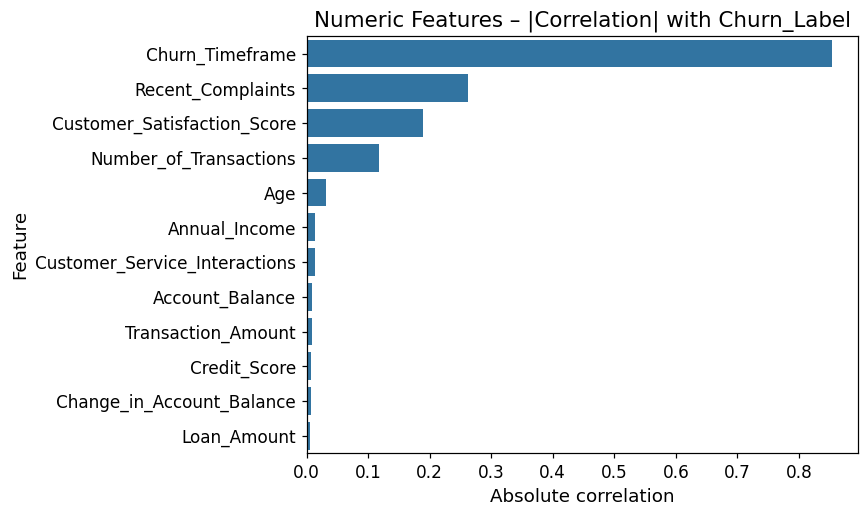

In [12]:
plt.figure(figsize=(8, max(4, 0.4*len(corr_df))))
sns.barplot(data=corr_df, x="AbsCorr", y="Feature")
plt.title("Numeric Features – |Correlation| with Churn_Label")
plt.xlabel("Absolute correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### 1.4: Categorical Features vs Churn_Label
**Objectives**
1. Quantify *contribution* of categorical variables to churn (churn rate by category vs overall churn rate).  
2. Statistical association via **Chi-square test**.  
3. **Effect size** via **Cramér’s V**.  
4. Rank categories by **lift** (category churn rate vs overall churn rate).

Feature: Branch
Overall churn rate: 0.3166
Chi2 p-value: 1 | Bias-corrected Cramér's V: 0.0000 | dof=0
Collapsed 4312 rare levels into 'Other' (min_count=30).
Cells with expected <5: 0.00%


,churn_rate,count,lift_vs_overall
Branch,,,
Other,0.3166,5000,1.0


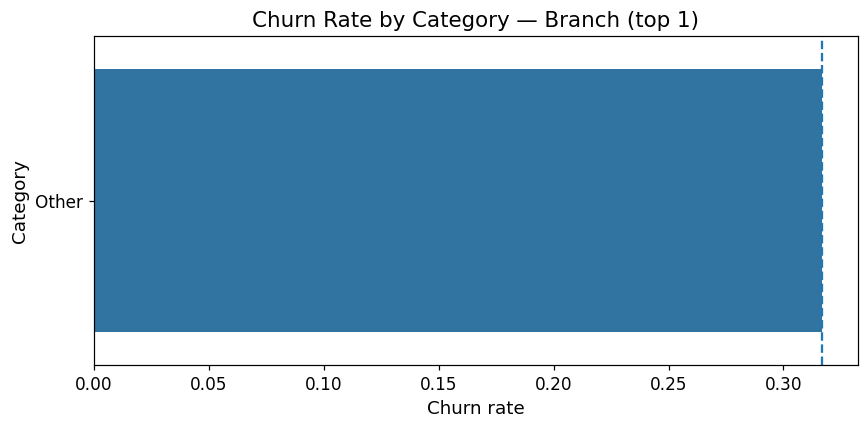

Feature: Branch
Overall churn rate: 0.3166
Chi2 p-value: 1 | Bias-corrected Cramér's V: 0.0000 | dof=0
Collapsed 4312 rare levels into 'Other' (min_count=30).
Cells with expected <5: 0.00%


,churn_rate,count,lift_vs_overall
Branch,,,
Other,0.3166,5000,1.0


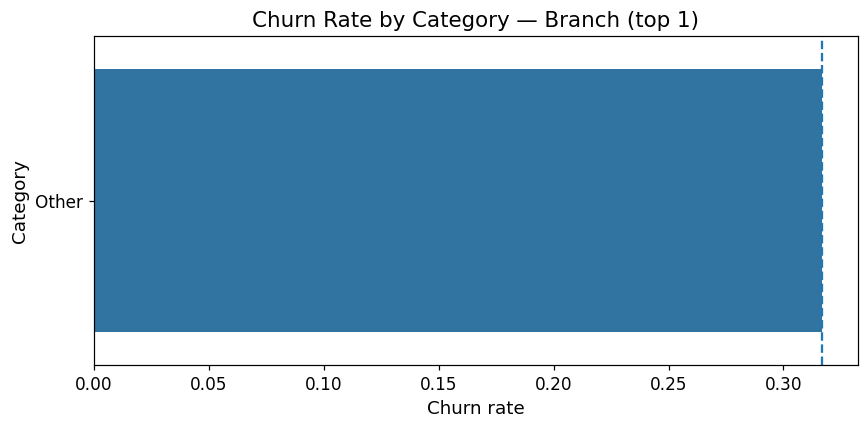

In [14]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cramers_v_corrected(contingency: pd.DataFrame) -> float:
    """Bias-corrected Cramér's V (Bergsma 2013)."""
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.to_numpy().sum()
    if n <= 1:
        return 0.0
    phi2 = chi2 / n
    r, k = contingency.shape
    # Bias correction
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = max(1e-12, min(rcorr - 1, kcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def categorical_drilldown(
    df: pd.DataFrame,
    feature: str,
    target_col: str = "Churn_Label",
    overall_churn_rate: float | None = None,
    top_mode: str = "lift",
    top_k: int = 25,
    min_count: int = 30
):
    if overall_churn_rate is None:
        overall_churn_rate = float(pd.to_numeric(df[target_col], errors="coerce").mean())

    s = df[feature].astype("string").fillna("NA")
    counts = s.value_counts(dropna=False)
    rare_levels = set(counts[counts < min_count].index)
    s_collapsed = s.where(~s.isin(rare_levels), other="Other")

    tmp = pd.DataFrame({feature: s_collapsed, target_col: df[target_col].values})
    grp = tmp.groupby(feature, dropna=False)[target_col].agg(churn_rate="mean", count="count")
    denom = np.nan if np.isclose(overall_churn_rate, 0.0) else overall_churn_rate
    grp["lift_vs_overall"] = grp["churn_rate"] / denom

    contingency = pd.crosstab(s_collapsed, df[target_col])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.to_numpy().sum()
    phi2 = chi2 / max(1, n)
    r, k = contingency.shape
    phi2corr = max(0.0, phi2 - ((k-1)*(r-1))/max(1, (n-1)))
    rcorr = r - ((r-1)**2)/max(1, (n-1))
    kcorr = k - ((k-1)**2)/max(1, (n-1))
    denom_cv = max(1e-12, min(rcorr-1, kcorr-1))
    v_corr = np.sqrt(phi2corr/denom_cv) if denom_cv>0 else 0.0
    expected_lt5_pct = (expected < 5).mean() * 100

    if top_mode == "count":
        plot_df = grp.sort_values("count", ascending=False)
    elif top_mode == "churn_rate":
        plot_df = grp.sort_values("churn_rate", ascending=False)
    else:
        plot_df = grp.sort_values("lift_vs_overall", ascending=False)
    plot_df = plot_df.head(top_k).reset_index()

    print(f"Feature: {feature}")
    print(f"Overall churn rate: {overall_churn_rate:.4f}")
    print(f"Chi2 p-value: {p:.4g} | Bias-corrected Cramér's V: {v_corr:.4f} | dof={dof}")
    print(f"Collapsed {len(rare_levels)} rare levels into 'Other' (min_count={min_count}).")
    print(f"Cells with expected <5: {expected_lt5_pct:.2f}%")
    display(grp.sort_values('churn_rate', ascending=False))

    n_bars = len(plot_df)
    height = min(max(0.35*n_bars + 3, 4), 16)
    plt.figure(figsize=(8, height))
    sns.barplot(data=plot_df, x="churn_rate", y=feature)
    plt.axvline(overall_churn_rate, linestyle="--")
    plt.title(f"Churn Rate by Category — {feature} (top {min(top_k, n_bars)})")
    plt.xlabel("Churn rate"); plt.ylabel("Category")
    plt.tight_layout(); plt.show()

    return grp, {"chi2_p": p, "cramers_v_corrected": v_corr, "expected_lt5_pct": expected_lt5_pct}

feature_to_inspect = "Branch"  # or any categorical column
_ = categorical_drilldown(df, feature="Branch", target_col="Churn_Label")

# === Use it for your selected feature (e.g., 'Branch') ===

grp, stats = categorical_drilldown(
    df=df,
    feature=feature_to_inspect,
    target_col="Churn_Label",   # adjust if different
    # overall_churn_rate=None   # omit; auto-computed
    top_mode="lift",
    top_k=25,
    min_count=30
)



## Part 3 — Feature Engineering (Appendix B)

We add deterministic features that **do not** use the target (safe outside CV):
- Tenure-related: `tenure_months`, `inactivity_days`
- Transaction-based: `txn_freq_per_month`, `avg_txn_amount`, `balance_volatility_index`
- Financial health: `loan_to_income`
- Service/satisfaction: `complaint_to_interaction_ratio`, `satisfaction_gap`
- Composite: `engagement_index` (z-score blend of activity vs inactivity)
  
**Fold-aware (target-dependent) contextual feature** (defined but not applied here):
- `GroupTargetRateEncoder`: computes **branch/region churn rate** *within each CV fold only* to avoid leakage (we’ll apply it in the CV pipeline later).

### 3.1 Reference snapshot (proxy)


In [16]:
# === Part 3 — Feature Engineering (tailored to your dataset, leakage-safe) ===
import numpy as np
import pandas as pdo

# Ensure dates are parsed (run this once after loading df)
if not np.issubdtype(df.get("Account_Open_Date", pd.Series([], dtype="datetime64[ns]")).dtype, np.datetime64):
    df["Account_Open_Date"] = pd.to_datetime(df["Account_Open_Date"], errors="coerce")
if not np.issubdtype(df.get("Last_Transaction_Date", pd.Series([], dtype="datetime64[ns]")).dtype, np.datetime64):
    df["Last_Transaction_Date"] = pd.to_datetime(df["Last_Transaction_Date"], errors="coerce")
if "Transaction_Date" in df.columns and not np.issubdtype(df["Transaction_Date"].dtype, np.datetime64):
    df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"], errors="coerce")
    
snapshot_date = df["Last_Transaction_Date"].max()

### 3.2 Tenure & inactivity

In [18]:
# tenure_months = time between Account_Open_Date and Last_Transaction_Date
tenure_days = (df["Last_Transaction_Date"] - df["Account_Open_Date"]).dt.days
df["tenure_months"] = tenure_days / 30.4375  # average month length

# inactivity_days = (snapshot_date - Last_Transaction_Date)
df["inactivity_days"] = (snapshot_date - df["Last_Transaction_Date"]).dt.days


### 3.3 Transaction-based features

In [20]:
# txn_freq_per_month = Number_of_Transactions / max(tenure_months, 1)
num_txn = pd.to_numeric(df["Number_of_Transactions"], errors="coerce")
df["txn_freq_per_month"] = num_txn / np.where(df["tenure_months"] < 1, 1, df["tenure_months"])

# avg_txn_amount = Transaction_Amount / max(Number_of_Transactions, 1)
txn_amt = pd.to_numeric(df["Transaction_Amount"], errors="coerce")
df["avg_txn_amount"] = txn_amt / np.where(num_txn < 1, 1, num_txn)


### 3.4 Balance volatility proxy

In [22]:
# balance_volatility_index = |Change_in_Account_Balance| / (|Account_Balance| + eps)
acct_bal = pd.to_numeric(df["Account_Balance"], errors="coerce")
chg_bal  = pd.to_numeric(df["Change_in_Account_Balance"], errors="coerce")
df["balance_volatility_index"] = np.abs(chg_bal) / (np.abs(acct_bal) + 1e-6)

### 3.5 Financial health

In [24]:
# loan_to_income = Loan_Amount / Annual_Income
loan = pd.to_numeric(df["Loan_Amount"], errors="coerce")
income = pd.to_numeric(df["Annual_Income"], errors="coerce")
df["loan_to_income"] = loan / np.where(np.abs(income) < 1e-9, np.nan, income)


### 3.6 Service & satisfaction

In [26]:
# complaint_to_interaction_ratio = Recent_Complaints / max(Customer_Service_Interactions, 1)
cs_inter = pd.to_numeric(df["Customer_Service_Interactions"], errors="coerce")
compl    = pd.to_numeric(df["Recent_Complaints"], errors="coerce")
df["complaint_to_interaction_ratio"] = compl / np.where(cs_inter < 1, 1, cs_inter)

# satisfaction_gap = normalized(Customer_Satisfaction_Score) - clamp(ratio, 0..1)
sat = pd.to_numeric(df["Customer_Satisfaction_Score"], errors="coerce")
sat_norm = np.where(np.nanmax(sat) <= 5, sat / 5.0, sat / 100.0)
ratio = np.clip(df["complaint_to_interaction_ratio"].astype(float), 0, 1)
df["satisfaction_gap"] = sat_norm - ratio

### 3.7 Composite engagement index (z-score blend)

In [28]:
def z(s):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

parts = [
    z(df["txn_freq_per_month"]),
    z(df["avg_txn_amount"]),
    -z(df["inactivity_days"]),
    -z(df["complaint_to_interaction_ratio"]),
]
df["engagement_index"] = np.nanmean(np.vstack([p.values for p in parts]), axis=0)

# Quick sanity check
cols_show = [
    "tenure_months","inactivity_days","txn_freq_per_month","avg_txn_amount",
    "balance_volatility_index","loan_to_income","complaint_to_interaction_ratio",
    "satisfaction_gap","engagement_index"
]
display(df[cols_show].head())

,tenure_months,inactivity_days,txn_freq_per_month,avg_txn_amount,balance_volatility_index,loan_to_income,complaint_to_interaction_ratio,satisfaction_gap,engagement_index
0,30.915811,6,0.258767,602.435000,0.039334,0.006861,2.0,-0.8,-0.224158
1,8.443532,28,0.473735,768.197500,0.105784,0.188993,0.0,0.6,0.445005
2,54.833676,17,0.036474,711.965000,0.029985,0.000000,0.0,0.2,0.487428
3,18.332649,4,0.981855,218.301667,0.002723,0.259908,2.0,-0.8,-0.279467
4,14.094456,30,1.206148,249.527059,0.058308,0.000000,1.0,-0.2,-0.099651


In [29]:
# =========================
# New Feature Engineering (stronger predictors; no leakage)
# =========================
import numpy as np
import pandas as pd

def add_stronger_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # ---- 0) Parse dates (your sample looks like '14/2/25' = day/month/yy)
    for col in ["Transaction_Date", "Account_Open_Date", "Last_Transaction_Date"]:
        if col in out.columns:
            out[col] = pd.to_datetime(out[col], errors="coerce", dayfirst=True)

    # Use the latest known date in the dataset as "as-of" anchor
    date_cols = [c for c in ["Transaction_Date","Last_Transaction_Date"] if c in out.columns]
    as_of = pd.concat([out[c] for c in date_cols], axis=0).max()
    if pd.isna(as_of):
        as_of = pd.Timestamp.today().normalize()

    # ---- 1) Core time features
    # tenure in months (clip to [0, inf))
    if {"Account_Open_Date"}.issubset(out.columns):
        tenure_days = (as_of - out["Account_Open_Date"]).dt.days
        out["tenure_months_strong"] = np.clip(tenure_days / 30.44, 0, None)
    else:
        out["tenure_months_strong"] = np.nan

    # days since last transaction
    if "Last_Transaction_Date" in out.columns:
        out["days_since_last_txn"] = (as_of - out["Last_Transaction_Date"]).dt.days.clip(lower=0)
    else:
        out["days_since_last_txn"] = np.nan

    # average days between transactions (stable pace proxy)
    eps = 1e-6
    if {"Last_Transaction_Date","Account_Open_Date","Number_of_Transactions"}.issubset(out.columns):
        span_days = (out["Last_Transaction_Date"] - out["Account_Open_Date"]).dt.days.clip(lower=0)
        out["avg_days_between_txns"] = span_days / (out["Number_of_Transactions"].replace(0, np.nan))
    else:
        out["avg_days_between_txns"] = np.nan

    # transaction intensity normalized by tenure
    if "Number_of_Transactions" in out.columns:
        out["txns_per_month"] = out["Number_of_Transactions"] / (out["tenure_months_strong"] + eps)
    else:
        out["txns_per_month"] = np.nan

    # recency vs frequency tension (higher can indicate disengagement)
    out["recency_over_frequency"] = out["days_since_last_txn"] / (out["txns_per_month"] + eps)

    # ---- 2) Monetary ratios & dynamics
    if {"Loan_Amount","Annual_Income"}.issubset(out.columns):
        out["loan_to_income_ratio_new"] = (out["Loan_Amount"] / (out["Annual_Income"] + eps)).replace([np.inf, -np.inf], np.nan)
    else:
        out["loan_to_income_ratio_new"] = np.nan

    if {"Account_Balance","Annual_Income"}.issubset(out.columns):
        out["balance_to_income_ratio"] = (out["Account_Balance"] / (out["Annual_Income"] + eps)).replace([np.inf, -np.inf], np.nan)
    else:
        out["balance_to_income_ratio"] = np.nan

    # normalized balance change (per day since last txn)
    if "Change_in_Account_Balance" in out.columns:
        out["balance_change_rate"] = out["Change_in_Account_Balance"] / (out["days_since_last_txn"] + 1.0)
    else:
        out["balance_change_rate"] = np.nan

    # credit risk proxy (higher is riskier): loan scaled by inverse credit score
    if {"Loan_Amount","Credit_Score"}.issubset(out.columns):
        out["loan_x_low_credit"] = out["Loan_Amount"] * (1.0 / (out["Credit_Score"] + eps))
    else:
        out["loan_x_low_credit"] = np.nan

    # debit/credit direction (one row view): Payment/Withdrawal treated as -1, Deposit/Transfer as +1
    if {"Transaction_Type","Transaction_Amount"}.issubset(out.columns):
        dir_map = {"Deposit": +1, "Transfer": +1, "Payment": -1, "Withdrawal": -1}
        out["txn_sign"] = out["Transaction_Type"].map(dir_map).fillna(0).astype(float)
        out["signed_txn_amount"] = out["txn_sign"] * out["Transaction_Amount"]
    else:
        out["signed_txn_amount"] = np.nan

    # ---- 3) Engagement & service ratios
    if {"Recent_Complaints","Customer_Service_Interactions"}.issubset(out.columns):
        out["complaint_rate"] = out["Recent_Complaints"] / (out["Customer_Service_Interactions"] + 1.0)
    else:
        out["complaint_rate"] = np.nan

    if {"Recent_Complaints","Number_of_Transactions"}.issubset(out.columns):
        out["complaints_per_txn"] = out["Recent_Complaints"] / (out["Number_of_Transactions"] + 1.0)
    else:
        out["complaints_per_txn"] = np.nan

    # Satisfaction gap already existed in your earlier FE; here we keep a stabilized version (0…1 scaled if raw is 1–5)
    if "Customer_Satisfaction_Score" in out.columns:
        # assuming 1..5 scale; change if your scale differs
        out["satisfaction_norm"] = (out["Customer_Satisfaction_Score"] - 1.0) / 4.0
    else:
        out["satisfaction_norm"] = np.nan

    # ---- 4) Activity trend ordinal encoding (-1, 0, +1)
    if "Account_Activity_Trend" in out.columns:
        trend_map = {"Decreasing": -1, "Stable": 0, "Increasing": +1}
        out["activity_trend_code"] = out["Account_Activity_Trend"].map(trend_map).fillna(0).astype(int)
    else:
        out["activity_trend_code"] = 0

    # ---- 5) Peer-relative features (Region & Branch medians)
    def add_peer_diff(col, by, newname):
        if col in out.columns and by in out.columns:
            grp_med = out.groupby(by)[col].transform("median")
            out[newname] = out[col] - grp_med
        else:
            out[newname] = np.nan

    for col in ["Account_Balance","Transaction_Amount","Number_of_Transactions","Customer_Satisfaction_Score"]:
        add_peer_diff(col, "Region", f"{col}_minus_region_med")
        add_peer_diff(col, "Branch", f"{col}_minus_branch_med")

    # ---- 6) Calendar / seasonality features from Transaction_Date
    if "Transaction_Date" in out.columns:
        td = out["Transaction_Date"]
        out["tx_month"]      = td.dt.month
        out["tx_quarter"]    = td.dt.quarter
        out["tx_dayofweek"]  = td.dt.dayofweek  # 0=Mon
        out["tx_is_month_end"] = td.dt.is_month_end.astype(int)
        out["tx_is_month_start"] = td.dt.is_month_start.astype(int)
    else:
        out[["tx_month","tx_quarter","tx_dayofweek","tx_is_month_end","tx_is_month_start"]] = np.nan

    # ---- 7) Product depth & interactions
    # has_loan flag (any nonzero loan)
    if "Loan_Amount" in out.columns:
        out["has_loan_flag"] = (out["Loan_Amount"].fillna(0) > 0).astype(int)
    else:
        out["has_loan_flag"] = 0

    # account type × satisfaction interaction (captures different baselines by product)
    if {"Account_Type","Customer_Satisfaction_Score"}.issubset(out.columns):
        # will be target/one-hot encoded later in CV; keep numeric interaction simple
        at_map = {k:i for i,k in enumerate(out["Account_Type"].dropna().unique(), start=1)}
        at_code = out["Account_Type"].map(at_map).fillna(0)
        out["accttype_x_satisfaction"] = at_code * out["Customer_Satisfaction_Score"].fillna(out["Customer_Satisfaction_Score"].median())
    else:
        out["accttype_x_satisfaction"] = np.nan

    # ---- 8) Cleanups & safety
    # clip absurd ratios to robust range
    for c in ["loan_to_income_ratio_new","balance_to_income_ratio","complaint_rate","complaints_per_txn","recency_over_frequency","loan_x_low_credit","balance_change_rate"]:
        if c in out.columns:
            out[c] = out[c].replace([np.inf, -np.inf], np.nan)
            out[c] = out[c].clip(lower=np.nanpercentile(out[c], 1), upper=np.nanpercentile(out[c], 99))

    # Make sure no negative tenure or negative avg_days_between_txns
    for c in ["tenure_months_strong","avg_days_between_txns"]:
        if c in out.columns:
            out[c] = out[c].clip(lower=0)

    return out

# ---- Run it
df_fe = add_stronger_features(df)

# Quick peek at the new columns
new_cols = [c for c in df_fe.columns if c not in df.columns]
print(f"Added {len(new_cols)} new features:", new_cols[:10], "...")
display(df_fe[new_cols].head())

Added 30 new features: ['tenure_months_strong', 'days_since_last_txn', 'avg_days_between_txns', 'txns_per_month', 'recency_over_frequency', 'loan_to_income_ratio_new', 'balance_to_income_ratio', 'balance_change_rate', 'loan_x_low_credit', 'txn_sign'] ...


,tenure_months_strong,days_since_last_txn,avg_days_between_txns,txns_per_month,recency_over_frequency,loan_to_income_ratio_new,balance_to_income_ratio,balance_change_rate,loan_x_low_credit,txn_sign,signed_txn_amount,complaint_rate,complaints_per_txn,satisfaction_norm,activity_trend_code,Account_Balance_minus_region_med,Account_Balance_minus_branch_med,Transaction_Amount_minus_region_med,Transaction_Amount_minus_branch_med,Number_of_Transactions_minus_region_med,Number_of_Transactions_minus_branch_med,Customer_Satisfaction_Score_minus_region_med,Customer_Satisfaction_Score_minus_branch_med,tx_month,tx_quarter,tx_dayofweek,tx_is_month_end,tx_is_month_start,has_loan_flag,accttype_x_satisfaction
0,31.110381,6,117.625000,0.257149,23.332696,0.006861,0.168077,-146.358571,2.238505,-1.0,-4819.48,1.0,0.222222,0.00,1,-26020.59,-24090.61,2302.540,372.68,-2.0,3.5,-2.0,-2.0,2,1,4,0,0,1,1
1,9.362681,28,64.250000,0.427228,65.538618,0.188993,0.145977,-100.003448,73.486335,1.0,3072.79,0.0,0.000000,0.50,0,-21557.63,18847.27,423.300,1672.41,-6.0,-5.0,0.0,1.0,2,1,2,0,0,1,6
2,55.387648,17,834.500000,0.036109,470.781977,0.000000,1.464791,-144.445000,0.000000,1.0,1423.93,0.0,0.000000,0.00,1,34642.84,0.00,-1093.010,0.00,-8.0,0.0,-2.0,0.0,3,1,2,0,0,0,2
3,18.462549,4,31.000000,0.974947,4.102785,0.259908,0.352164,30.946000,117.101738,1.0,3929.43,2.0,0.105263,0.00,0,5729.83,0.00,1472.765,0.00,7.0,0.0,-2.0,0.0,2,1,1,0,0,1,1
4,15.078844,30,25.235294,1.127407,26.609702,0.000000,0.568176,51.888387,0.000000,-1.0,-4241.96,1.0,0.055556,0.75,-1,-22730.03,0.00,1659.120,0.00,6.0,0.0,1.0,0.0,1,1,1,0,0,0,8


In [30]:
# === FE Sanity Check (updated for NEW FE set; robust) ===
import numpy as np
import pandas as pd

df_raw = df.copy()
df = df_fe

def fe_sanity_report_new(df: pd.DataFrame, target="Churn_Label"):
    checks = []

    # -- Make sure date cols are datetime
    for col in ["Account_Open_Date", "Last_Transaction_Date", "Transaction_Date"]:
        if col in df.columns and not np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = pd.to_datetime(df[col], errors="coerce")

    # -- Date-order sanity (open <= last)
    if {"Account_Open_Date","Last_Transaction_Date"}.issubset(df.columns):
        bad_order = (df["Last_Transaction_Date"] < df["Account_Open_Date"]).sum()
        checks.append(("date_order_open<=last (violations)", int(bad_order)))

    # --- NEW engineered feature sets (from add_stronger_features)
    new_eng_cols = [
        # core time/pace
        "tenure_months_strong","days_since_last_txn","avg_days_between_txns",
        "txns_per_month","recency_over_frequency",
        # monetary & risk
        "loan_to_income_ratio_new","balance_to_income_ratio","balance_change_rate","loan_x_low_credit",
        "signed_txn_amount",
        # service/engagement
        "complaint_rate","complaints_per_txn","satisfaction_norm","activity_trend_code",
        # peer-relative (region/branch medians)
        "Account_Balance_minus_region_med","Transaction_Amount_minus_region_med",
        "Number_of_Transactions_minus_region_med","Customer_Satisfaction_Score_minus_region_med",
        "Account_Balance_minus_branch_med","Transaction_Amount_minus_branch_med",
        "Number_of_Transactions_minus_branch_med","Customer_Satisfaction_Score_minus_branch_med",
        # calendar/seasonality
        "tx_month","tx_quarter","tx_dayofweek","tx_is_month_end","tx_is_month_start",
        # product depth / interactions
        "has_loan_flag","accttype_x_satisfaction",
    ]

    # which of the above actually exist in this df
    present_cols = [c for c in new_eng_cols if c in df.columns]
    missing_cols  = [c for c in new_eng_cols if c not in df.columns]

    # --- Missingness & negativity audit for NEW engineered (only where non-negative makes sense)
    nonneg_ok = {
        "tenure_months_strong","days_since_last_txn","avg_days_between_txns","txns_per_month",
        "recency_over_frequency","loan_to_income_ratio_new","balance_to_income_ratio",
        "complaint_rate","complaints_per_txn","satisfaction_norm",
        "tx_month","tx_quarter","tx_dayofweek","tx_is_month_end","tx_is_month_start",
        "has_loan_flag","activity_trend_code"  # note: activity_trend_code can be -1/0/1; we won't flag it as negative-error
    }
    # remove activity_trend_code from nonneg checks (it legitimately has -1)
    nonneg_ok = nonneg_ok - {"activity_trend_code"}

    rows = []
    for c in present_cols:
        miss = float(df[c].isna().mean())
        neg_rate = float((df[c] < 0).mean()) if c in nonneg_ok else np.nan
        rows.append({"feature": c,
                     "missing_rate": round(miss, 4),
                     "neg_rate(if-applicable)": (None if np.isnan(neg_rate) else round(neg_rate, 4))})

    audit_df = pd.DataFrame(rows).sort_values("missing_rate", ascending=False) if rows else pd.DataFrame(columns=["feature","missing_rate","neg_rate(if-applicable)"])

    print("NEW FE — missing/negativity audit:")
    display(audit_df)

    if missing_cols:
        print("\nNEW FE — not found in dataframe (skip if intentionally omitted):")
        print(missing_cols)

    # --- Correlations: (a) among NEW engineered only, (b) among ALL numerics
    def top_corrs(df_use: pd.DataFrame, feat_list=None, target_col=target, k=15, title=""):
        if target_col not in df_use.columns:
            print(f"\n{title}: target '{target_col}' not in df; skip.")
            return
        num_feats_all = df_use.select_dtypes(include=[np.number]).columns.tolist()
        if feat_list is not None:
            num_feats = [c for c in feat_list if c in num_feats_all and c != target_col]
        else:
            num_feats = [c for c in num_feats_all if c != target_col]
        rows = []
        for col in num_feats:
            pair = df_use[[col, target_col]].dropna()
            r = pair[col].corr(pair[target_col]) if pair[col].nunique()>1 and pair[target_col].nunique()>1 else np.nan
            rows.append({"feature": col, "corr_with_target": r, "abs_corr": (abs(r) if pd.notna(r) else np.nan)})
        corr_df = pd.DataFrame(rows)
        if len(corr_df):
            top = corr_df.sort_values(by="abs_corr", ascending=False).head(k)
            print(f"\nTop {k} |correlation| with target — {title}")
            display(top.style.format({"corr_with_target":"{:.4f}","abs_corr":"{:.4f}"}))
        else:
            print(f"\n{title}: no numeric features to compute correlation.")

    top_corrs(df, feat_list=present_cols, title="NEW engineered features")
    top_corrs(df, feat_list=None, title="ALL numeric features")

    # --- Final sanity flags
    print("\nSanity checks:")
    for k, v in checks:
        print(f"  {k:40s}: {v}")

# Run it (use df or df_fe depending on your variable)
fe_sanity_report_new(df)

NEW FE — missing/negativity audit:


,feature,missing_rate,neg_rate(if-applicable)
0,tenure_months_strong,0.0,0.0
15,Transaction_Amount_minus_region_med,0.0,NaN
27,has_loan_flag,0.0,0.0
26,tx_is_month_start,0.0,0.0
25,tx_is_month_end,0.0,0.0
24,tx_dayofweek,0.0,0.0
23,tx_quarter,0.0,0.0
22,tx_month,0.0,0.0
21,Customer_Satisfaction_Score_minus_branch_med,0.0,NaN
20,Number_of_Transactions_minus_branch_med,0.0,NaN



Top 15 |correlation| with target — NEW engineered features


,feature,corr_with_target,abs_corr
11,complaints_per_txn,0.2449,0.2449
17,Customer_Satisfaction_Score_minus_region_med,-0.1887,0.1887
12,satisfaction_norm,-0.1887,0.1887
10,complaint_rate,0.1610,0.1610
28,accttype_x_satisfaction,-0.1424,0.1424
16,Number_of_Transactions_minus_region_med,-0.1167,0.1167
2,avg_days_between_txns,0.1040,0.1040
4,recency_over_frequency,0.0937,0.0937
21,Customer_Satisfaction_Score_minus_branch_med,-0.0537,0.0537
9,signed_txn_amount,-0.0327,0.0327



Top 15 |correlation| with target — ALL numeric features


,feature,corr_with_target,abs_corr
11,Churn_Timeframe,0.8534,0.8534
19,satisfaction_gap,-0.2956,0.2956
8,Recent_Complaints,0.2619,0.2619
33,complaints_per_txn,0.2449,0.2449
42,Customer_Satisfaction_Score_minus_region_med,-0.1887,0.1887
34,satisfaction_norm,-0.1887,0.1887
10,Customer_Satisfaction_Score,-0.1887,0.1887
18,complaint_to_interaction_ratio,0.1759,0.1759
32,complaint_rate,0.1610,0.1610
50,accttype_x_satisfaction,-0.1424,0.1424



Sanity checks:
  date_order_open<=last (violations)      : 98


In [31]:
df.describe()

,Age,Account_Balance,Transaction_Date,Transaction_Amount,Loan_Amount,Credit_Score,Annual_Income,Account_Open_Date,Last_Transaction_Date,Number_of_Transactions,Customer_Service_Interactions,Recent_Complaints,Change_in_Account_Balance,Customer_Satisfaction_Score,Churn_Label,Churn_Timeframe,tenure_months,inactivity_days,txn_freq_per_month,avg_txn_amount,balance_volatility_index,loan_to_income,complaint_to_interaction_ratio,satisfaction_gap,engagement_index,tenure_months_strong,days_since_last_txn,avg_days_between_txns,txns_per_month,recency_over_frequency,loan_to_income_ratio_new,balance_to_income_ratio,balance_change_rate,loan_x_low_credit,txn_sign,signed_txn_amount,complaint_rate,complaints_per_txn,satisfaction_norm,activity_trend_code,Account_Balance_minus_region_med,Account_Balance_minus_branch_med,Transaction_Amount_minus_region_med,Transaction_Amount_minus_branch_med,Number_of_Transactions_minus_region_med,Number_of_Transactions_minus_branch_med,Customer_Satisfaction_Score_minus_region_med,Customer_Satisfaction_Score_minus_branch_med,tx_month,tx_quarter,tx_dayofweek,tx_is_month_end,tx_is_month_start,has_loan_flag,accttype_x_satisfaction
count,5000.000000,5000.000000,5000,5000.000000,5000.00000,5000.000000,5000.000000,5000,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.930000,50378.659748,2025-02-14 08:03:15.839999744,2519.289100,7661.64505,574.537800,110500.612678,2022-08-15 14:34:39.360000,2025-02-13 12:18:08.639999744,10.468200,2.530000,1.016000,46.275696,3.036600,0.316600,2.124400,29.992779,44.487400,1.064031,445.593739,0.133728,0.095617,0.548540,0.173580,2.806644e-17,31.451794,44.487400,165.315491,7.601365e+03,239.248287,0.092253,0.632828,-3.270732,14.411833,-0.029200,-97.416016,0.408893,0.133931,0.509150,0.027600,-236.761220,-34.129390,-32.366420,-2.751658,-0.027800,-0.02260,0.036600,-0.001800,1.998400,1.0,3.030800,0.024600,0.034200,0.297200,6.119800
min,18.000000,509.950000,2025-01-01 00:00:00,10.480000,0.00000,300.000000,20019.560000,2020-01-01 00:00:00,2025-01-01 00:00:00,1.000000,0.000000,0.000000,-4999.230000,1.000000,0.000000,0.000000,-2.726899,0.000000,0.016216,0.704737,0.000082,0.000000,0.000000,-0.800000,-1.248578e+00,0.000000,0.000000,0.000000,1.592883e-02,0.000000,0.000000,0.013722,-1102.175000,0.000000,-1.000000,-4999.930000,0.000000,0.000000,0.000000,-1.000000,-51556.540000,-80619.560000,-2637.270000,-4548.150000,-10.000000,-17.00000,-2.000000,-4.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
25%,31.000000,26085.310000,2025-01-23 00:00:00,1258.035000,0.00000,438.000000,66260.917500,2021-04-23 18:00:00,2025-01-23 00:00:00,5.000000,1.000000,0.000000,-2474.207500,2.000000,0.000000,0.000000,14.316222,22.000000,0.181005,121.372770,0.026053,0.000000,0.000000,-0.200000,-2.971768e-01,15.735874,22.000000,41.426692,1.732007e-01,38.757094,0.000000,0.234948,-54.521400,0.000000,-1.000000,-2682.710000,0.000000,0.000000,0.250000,-1.000000,-24491.862500,0.000000,-1289.650000,0.000000,-5.000000,0.00000,-1.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,3.000000
50%,44.000000,50587.400000,2025-02-14 00:00:00,2548.545000,0.00000,573.000000,110586.580000,2022-08-28 00:00:00,2025-02-13 00:00:00,11.000000,3.000000,1.000000,36.780000,3.000000,0.000000,0.000000,29.535934,45.000000,0.353924,239.957295,0.050082,0.000000,0.333333,0.200000,-9.868648e-03,31.044678,45.000000,86.000000,3.364569e-01,114.191391,0.000000,0.460986,1.002281,0.000000,-1.000000,-163.205000,0.250000,0.090909,0.500000,0.000

In [32]:
df.shape

(5000, 65)

## Part 4 — Stratified Train–Test Split

We now:
1. Separate features (X) and target (`Churn_Label`).
2. Perform an **80/20 stratified split**:
   - Ensures class balance (churn vs non-churn) is preserved.
   - Uses a fixed random seed for reproducibility.
3. Validate that class distribution in train/test ≈ overall dataset.

In [34]:
from sklearn.model_selection import train_test_split

# Target column
target_col = "Churn_Label"

# Features: drop ID + target
id_cols = ["Customer_ID"]  # per your dataset
# Drop known leakage columns
leakage_cols = ["Churn_Timeframe", "Last_Transaction_Date", "Transaction_Date"]

# Rebuild features without target, ID, or leakage
X = df.drop(columns=id_cols + [target_col] + leakage_cols, errors="ignore")
y = df[target_col]

# Stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Shapes:")
print("  Train:", X_train.shape, y_train.shape)
print("  Test :", X_test.shape, y_test.shape)

print("\nChurn distribution:")
print("  Overall:", y.mean())
print("  Train  :", y_train.mean())
print("  Test   :", y_test.mean())


Shapes:
  Train: (4000, 60) (4000,)
  Test : (1000, 60) (1000,)

Churn distribution:
  Overall: 0.3166
  Train  : 0.3165
  Test   : 0.317


**Expected output:**
- Train ≈ 4000 rows, Test ≈ 1000 rows (from ~5000 total).
- Churn ratio in Train/Test close to overall (e.g., if overall churn = 0.21, both sets ≈ 0.21).


## Part 5 — Outside-CV Preprocessing

**Goal**
1. Handle missing values (numeric → median; categorical → mode or "Unknown").
2. Identify categorical vs numeric features.
3. Apply one-hot encoding (OHE) to **low-cardinality categoricals**:
   - Suitable for demographic variables like Gender, Marital_Status, Account_Type.
   - Prevents leakage since OHE is not target-dependent.
4. Keep engineered numeric features from Part 3 as is.

**Note:** High-cardinality categoricals (e.g., Branch, Region) will be handled later inside CV using the fold-aware target encoder.

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Identify feature types ---
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

# Drop Branch/Region from categorical here (they’ll get target encoding inside CV)
high_card_cols = ["Branch","Region"]
categorical_low = [c for c in categorical_features if c not in high_card_cols]

print("Numeric features (sample):", numeric_features[:10])
print("Low-card categorical:", categorical_low)
print("High-card categorical (later inside CV):", high_card_cols)


Numeric features (sample): ['Age', 'Account_Balance', 'Transaction_Amount', 'Loan_Amount', 'Credit_Score', 'Annual_Income', 'Number_of_Transactions', 'Customer_Service_Interactions', 'Recent_Complaints', 'Change_in_Account_Balance']
Low-card categorical: ['Gender', 'Account_Type', 'Transaction_Type', 'Loan_Type', 'Is_Employed', 'Marital_Status', 'Account_Activity_Trend']
High-card categorical (later inside CV): ['Branch', 'Region']


In [38]:
# --- Define transformers ---
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer to apply preprocessing
preprocessor_outside = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_low)
    ],
    remainder="passthrough"  # leave other columns (including Branch/Region) as-is
)

# Fit+transform training data
X_train_pre = preprocessor_outside.fit_transform(X_train)
X_test_pre  = preprocessor_outside.transform(X_test)

print("Transformed train shape:", X_train_pre.shape)
print("Transformed test shape :", X_test_pre.shape)


Transformed train shape: (4000, 76)
Transformed test shape : (1000, 76)


### Outputs of Part 5
- Numeric columns imputed with median.
- Low-cardinality categoricals → OHE-expanded features.
- Branch/Region left untouched for Part 6 (inside-CV target encoding).
- `X_train_pre` and `X_test_pre` are ready for pipelines.


## Part 6 — Inside-CV Preprocessing (Leakage-Safe)

**Why inside CV?**  
Anything that *learns from the data distribution (or the target)* must be fit **only on the training fold** and re-applied to the validation fold:
- Standardization / scaling
- **SMOTE** (or any resampling)
- **Target / group encoders** (e.g., churn rate by Branch/Region)

**What we’ll do per fold:**
1. Split train/valid with `StratifiedKFold`.
2. Fit imputers/encoders **on the training fold only**:
   - Numeric: median imputer → StandardScaler
   - Low-card categoricals: mode imputer → OneHotEncoder
   - High-card categoricals (Branch, Region): **GroupTargetRateEncoder** (from Part 3)
3. Optionally apply **SMOTE** on the assembled training matrix.
4. Train the model, evaluate on valid, collect metrics + timing.


In [41]:
# --- Part 6: Fold-prep utilities (version-safe, leakage-safe) ---
import numpy as np
import pandas as pd
import sklearn
from packaging import version
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.validation import check_is_fitted

# Optional SMOTE (will gracefully disable if not installed)
try:
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

# Version-safe OneHotEncoder kwargs
ohe_params = {}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

HIGH_CARD_COLS = [c for c in ["Branch", "Region"] if c in X_train.columns]

from dataclasses import dataclass

@dataclass
class GroupTargetRateEncoder:
    cols: list
    min_count: int = 20
    smoothing: float = 10.0
    mapping_: dict = None
    global_mean_: float = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.mapping_ = {}
        self.global_mean_ = float(np.mean(y))
        for col in self.cols:
            vc = X[col].astype("string").fillna("NA")
            dfm = pd.DataFrame({col: vc, "y": y})
            agg = dfm.groupby(col)["y"].agg(["mean","count"])
            smooth = (agg["count"] * agg["mean"] + self.smoothing * self.global_mean_) / (agg["count"] + self.smoothing)
            self.mapping_[col] = smooth.to_dict()
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        mats = []
        for col in self.cols:
            m = self.mapping_.get(col, {})
            s = X[col].astype("string").fillna("NA").map(m).fillna(self.global_mean_).astype(float)
            mats.append(s.to_numpy().reshape(-1,1))
        return np.hstack(mats) if mats else np.empty((len(X), 0))

@dataclass
class FoldPreprocessors:
    num_imputer: SimpleImputer
    num_scaler: StandardScaler
    cat_imputer: SimpleImputer
    cat_ohe: OneHotEncoder
    gte: GroupTargetRateEncoder
    num_cols: list
    cat_low_cols: list
    high_card_cols: list
    ohe_cols_: list = None

def fit_fold_preprocessors(
    X: pd.DataFrame, y: pd.Series,
    numeric_features: list, categorical_low: list, high_card_cols: list
) -> FoldPreprocessors:
    num_imputer = SimpleImputer(strategy="median")
    X_num = num_imputer.fit_transform(X[numeric_features])

    num_scaler = StandardScaler()
    X_num = num_scaler.fit_transform(X_num)

    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_cat = cat_imputer.fit_transform(X[categorical_low])

    cat_ohe = OneHotEncoder(**_OHE_KW)
    X_ohe = cat_ohe.fit_transform(X_cat)
    # ohe_cols = getattr(cat_ohe, "get_feature_names_out", cat_ohe.get_feature_names)(categorical_low)
    ohe_cols = (cat_ohe.get_feature_names_out(categorical_low)
            if hasattr(cat_ohe, "get_feature_names_out")
            else cat_ohe.get_feature_names(categorical_low))

    gte = GroupTargetRateEncoder(cols=high_card_cols, min_count=20, smoothing=10.0).fit(X, y)

    return FoldPreprocessors(
        num_imputer=num_imputer, num_scaler=num_scaler,
        cat_imputer=cat_imputer, cat_ohe=cat_ohe, gte=gte,
        num_cols=list(numeric_features), cat_low_cols=list(categorical_low),
        high_card_cols=list(high_card_cols), ohe_cols_=list(ohe_cols)
    )


def transform_with_preprocessors(
    fp: FoldPreprocessors, X: pd.DataFrame,
    numeric_features: list, categorical_low: list, high_card_cols: list
):
    X_num = fp.num_imputer.transform(X[numeric_features])
    X_num = fp.num_scaler.transform(X_num)

    if categorical_low:
        X_cat = fp.cat_imputer.transform(X[categorical_low])
        X_ohe = fp.cat_ohe.transform(X_cat)
        try:
            X_ohe = X_ohe.toarray()
        except Exception:
            pass
    else:
        X_ohe = np.empty((len(X), 0))

    X_gte = fp.gte.transform(X)

    X_mat = np.hstack([X_num, X_ohe, X_gte])
    feat_names = list(fp.num_cols) + list(fp.ohe_cols_) + [f"gte_{c}" for c in fp.high_card_cols]
    return X_mat, feat_names

In [42]:
# === SMOTE verification on a single fold ===
from sklearn.model_selection import StratifiedKFold
from collections import Counter

def verify_smote_once(
    X: pd.DataFrame, y: pd.Series,
    numeric_features: list, categorical_low: list, high_card_cols: list,
    random_state: int = 42
):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    tr_idx, va_idx = next(iter(skf.split(X, y)))
    X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
    y_tr, y_va = y.iloc[tr_idx].copy(), y.iloc[va_idx].copy()

    # Fit per-fold preprocessors on TRAIN only
    pre = fit_fold_preprocessors(X_tr, y_tr, numeric_features, categorical_low, high_card_cols)
    Xtr_mat, _ = transform_with_preprocessors(pre, X_tr, numeric_features, categorical_low, high_card_cols)
    Xva_mat, _ = transform_with_preprocessors(pre, X_va, numeric_features, categorical_low, high_card_cols)

    print("Class counts (raw):")
    print("  Train:", Counter(y_tr.values))
    print("  Valid:", Counter(y_va.values))

    # Apply SMOTE to TRAIN ONLY
    if IMB_AVAILABLE:
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=random_state)
        Xtr_sm, ytr_sm = sm.fit_resample(Xtr_mat, y_tr.values)
        print("\nAfter SMOTE (train only):")
        print("  Train:", Counter(ytr_sm))
        print("  Valid (unchanged):", Counter(y_va.values))
    else:
        print("\nimblearn not available; SMOTE check skipped.")

# run once on your current train split
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
HIGH_CARD_COLS = [c for c in ["Branch","Region"] if c in X_train.columns]
categorical_low = [c for c in categorical_features if c not in HIGH_CARD_COLS]

verify_smote_once(X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)

Class counts (raw):
  Train: Counter({0: 2188, 1: 1012})
  Valid: Counter({0: 546, 1: 254})

After SMOTE (train only):
  Train: Counter({1: 2188, 0: 2188})
  Valid (unchanged): Counter({0: 546, 1: 254})


### 6.1 Leakage-Safe wrapper for use *inside* scikit-learn searches

In [44]:
# ==== D. Wrapper estimator (clone-safe + classes_) ====
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class LeakageSafeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator,
                 numeric_features=(),
                 categorical_low=(),
                 high_card_cols=(),
                 oversampling="none",
                 random_state=42):
        self.base_estimator   = base_estimator
        self.numeric_features = tuple(numeric_features)
        self.categorical_low  = tuple(categorical_low)
        self.high_card_cols   = tuple(high_card_cols)
        self.oversampling     = oversampling
        self.random_state     = random_state

    def fit(self, X, y):
        self._pre_ = fit_fold_preprocessors(
            X, y, list(self.numeric_features), list(self.categorical_low), list(self.high_card_cols)
        )
        X_mat, _ = transform_with_preprocessors(
            self._pre_, X, list(self.numeric_features), list(self.categorical_low), list(self.high_card_cols)
        )
        y_fit = y.values if hasattr(y, "values") else y

        if str(self.oversampling).lower() == "smote" and IMB_AVAILABLE:
            sm = SMOTE(random_state=self.random_state)
            X_mat, y_fit = sm.fit_resample(X_mat, y_fit)

        self._est_ = clone(self.base_estimator)
        self._est_.fit(X_mat, y_fit)

        self.classes_ = np.unique(y_fit)
        self.n_features_in_ = X_mat.shape[1]
        return self

    def _transform(self, X):
        return transform_with_preprocessors(
            self._pre_, X, list(self.numeric_features), list(self.categorical_low), list(self.high_card_cols)
        )[0]

    def predict(self, X):
        return self._est_.predict(self._transform(X))

    def predict_proba(self, X):
        X_mat = self._transform(X)
        if hasattr(self._est_, "predict_proba"):
            proba = self._est_.predict_proba(X_mat)
        elif hasattr(self._est_, "decision_function"):
            s = self._est_.decision_function(X_mat)
            s = (s - s.min()) / (s.max() - s.min() + 1e-9)
            proba = np.c_[1-s, s]
        else:
            p = self._est_.predict(X_mat)
            proba = np.c_[1-p, p]
        if hasattr(self._est_, "classes_"):
            order = np.argsort(self._est_.classes_)
            proba = proba[:, order]
        return proba

## Part 7 — Stratified K-Fold Harness (Metrics + Timing)

We’ll build a reusable evaluator:

**Inputs**
- `models`: dict of name → estimator (e.g., LogisticRegression())
- `n_splits`: k folds
- `oversampling`: `"none"` or `"smote"`
- `random_state`: reproducibility

**Outputs**
- A tidy DataFrame with per-fold metrics: **accuracy, precision, recall, f1, ROC AUC**, plus **train/infer time**.
- An aggregate summary you can sort by your preferred metric.


In [46]:
# --- Part 7: CV Harness ---
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

def safe_auc(y_true, y_score):
    """Compute ROC AUC if possible; else return np.nan."""
    try:
        return roc_auc_score(y_true, y_score)
    except Exception:
        return np.nan

def get_scores(y_true, y_pred, y_score):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": safe_auc(y_true, y_score),
    }

def evaluate_models_cv(
    models: dict,
    X: pd.DataFrame,
    y: pd.Series,
    numeric_features: list,
    categorical_low: list,
    high_card_cols: list,
    n_splits: int = 5,
    oversampling: str = "none",
    random_state: int = 42
):
    """
    Returns: (per_fold_df, summary_df)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []

    fold_idx = 0
    for tr_idx, va_idx in skf.split(X, y):
        fold_idx += 1
        X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
        y_tr, y_va = y.iloc[tr_idx].copy(), y.iloc[va_idx].copy()

        # --- Fit per-fold preprocessors on training fold only
        pre = fit_fold_preprocessors(X_tr, y_tr, numeric_features, categorical_low, high_card_cols)

        # --- Transform both splits
        Xtr_mat, feat_names = transform_with_preprocessors(pre, X_tr, numeric_features, categorical_low, high_card_cols)
        Xva_mat, _          = transform_with_preprocessors(pre, X_va, numeric_features, categorical_low, high_card_cols)

        # --- Optional oversampling (only on training)
        if oversampling.lower() == "smote":
            if IMB_AVAILABLE:
                sm = SMOTE(random_state=random_state)
                Xtr_mat, y_tr = sm.fit_resample(Xtr_mat, y_tr)
            else:
                print("⚠️ SMOTE requested but imblearn not installed. Skipping oversampling.")
        elif oversampling.lower() == "gan":
            print("⚠️ GAN oversampling not enabled in this environment. Consider SDV/CTGAN if available. Skipping.")
        # else: none

        # --- Train & evaluate all models on this fold
        for name, est in models.items():
            # Train timing
            t0 = time.perf_counter()
            est.fit(Xtr_mat, y_tr)
            train_time = time.perf_counter() - t0

            # Inference timing
            t1 = time.perf_counter()
            y_pred = est.predict(Xva_mat)
            infer_time = time.perf_counter() - t1

            # Probabilities / scores
            if hasattr(est, "predict_proba"):
                y_score = est.predict_proba(Xva_mat)[:, 1]
            elif hasattr(est, "decision_function"):
                y_score = est.decision_function(Xva_mat)
            else:
                y_score = y_pred  # fallback (not ideal for AUC)

            m = get_scores(y_va, y_pred, y_score)
            m.update({
                "fold": fold_idx,
                "model": name,
                "train_time_sec": train_time,
                "infer_time_sec": infer_time,
            })
            rows.append(m)

    per_fold_df = pd.DataFrame(rows)
    # Summary across folds
    summary = (per_fold_df
               .groupby("model", as_index=False)
               .agg({
                   "accuracy":"mean","precision":"mean","recall":"mean","f1":"mean","roc_auc":"mean",
                   "train_time_sec":"mean","infer_time_sec":"mean"
               })
               .sort_values(["roc_auc","f1","recall"], ascending=False)
               .reset_index(drop=True))
    return per_fold_df, summary


### 7.1 Define Baseline ML Models & Run CV

We’ll start with a strong classic set:
- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **XGBoost** (if `xgboost` is installed; otherwise skip)

In [48]:
# Define models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "LogReg": LogisticRegression(max_iter=1000, n_jobs=None if version.parse(sklearn.__version__) >= version.parse("1.3") else None),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ),
}

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=-1, eval_metric="logloss"
    )
except Exception:
    print("ℹ️ xgboost not installed — skipping XGBoost.")

# Re-identify feature types based on current X_train
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
categorical_low = [c for c in categorical_features if c not in HIGH_CARD_COLS]

# Run CV
per_fold_df, summary_df = evaluate_models_cv(
    models=models,
    X=X_train, y=y_train,
    numeric_features=numeric_features,
    categorical_low=categorical_low,
    high_card_cols=HIGH_CARD_COLS,
    n_splits=5,
    oversampling="smote",     # "none" or "smote" (GAN placeholder prints a note)
    random_state=42
)

print("Per-fold results:")
display(per_fold_df)

print("Summary (mean across folds):")
display(summary_df)


Per-fold results:


,accuracy,precision,recall,f1,roc_auc,fold,model,train_time_sec,infer_time_sec
0,0.63750,0.407216,0.311024,0.352679,0.638149,1,LogReg,0.954089,0.005751
1,0.61125,0.378723,0.350394,0.364008,0.541497,1,DecisionTree,0.126531,0.000448
2,0.67250,0.416667,0.078740,0.132450,0.670211,1,RandomForest,0.783295,0.025584
3,0.66125,0.292683,0.047244,0.081356,0.643506,1,XGBoost,0.535450,0.004332
4,0.68625,0.505814,0.343874,0.409412,0.705588,2,LogReg,0.354604,0.000194
5,0.60375,0.355856,0.312253,0.332632,0.525414,2,DecisionTree,0.118962,0.000165
6,0.70000,0.578313,0.189723,0.285714,0.719714,2,RandomForest,0.632559,0.026080
7,0.66875,0.464706,0.312253,0.373522,0.650750,2,XGBoost,0.549572,0.005509
8,0.68875,0.510870,0.371542,0.430206,0.699908,3,LogReg,0.085312,0.000095
9,0.61125,0.394161,0.426877,0.409867,0.561702,3,DecisionTree,0.134992,0.000343


Summary (mean across folds):


,model,accuracy,precision,recall,f1,roc_auc,train_time_sec,infer_time_sec
0,RandomForest,0.68450,0.490149,0.167527,0.244146,0.701922,0.663226,0.025675
1,LogReg,0.67025,0.470957,0.327817,0.386251,0.675229,0.373225,0.001267
2,XGBoost,0.66300,0.379685,0.168342,0.220079,0.635519,0.571403,0.006519
3,DecisionTree,0.59425,0.358417,0.357035,0.356772,0.530571,0.117828,0.000355


### 7.2 Deep Learning Baselines (ANN / DNN) — Leakage-Safe CV

**Design**
- Uses the same **per-fold preprocessors** as ML (median→scale for numeric, OHE for low-card categorical, GroupTargetRateEncoder for Branch/Region).
- Two baselines:
  - **ANN** (shallow): 1–2 hidden layers for a fast baseline.
  - **DNN** (deeper): 4–6 smaller layers with dropout + batch norm.
- **EarlyStopping** + **ReduceLROnPlateau**.
- **Class weights** computed **within each fold** to address imbalance (alternative to SMOTE for DL).
- Metrics: accuracy, precision, recall, F1, ROC-AUC + train/infer time.

> Note: Requires `tensorflow` installed. If not available, the cell will warn and skip.
#### 7.2.1 — Keras builders and CV evaluator

In [50]:
# 7.2.1 — Keras builders and CV evaluator
import numpy as np
import time
from tensorflow.keras import backend as K

try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False
    print("⚠️ TensorFlow not available. DL baselines will be skipped.\n", e)

def set_tf_determinism(seed: int = 42):
    if not TF_AVAILABLE:
        return
    tf.keras.utils.set_random_seed(seed)
    try:
        # Avoid GPU memory pre-allocation if a GPU exists
        gpus = tf.config.list_physical_devices('GPU')
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

## Define the Custom F1 Metric (Safe for Binary shapes)
def f1_metric(y_true, y_pred):
    """
    Computes F1 Score.
    Safe for shape mismatch: handles (N, 1) vs (N,) automatically.
    """
    # Ensure data types match
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")

    # Round predictions to 0 or 1 (assuming threshold 0.5)
    y_pred_binary = K.round(y_pred)

    # Calculate True Positives, Predicted Positives, Possible Positives
    # K.epsilon() prevents division by zero
    true_positives = K.sum(K.round(K.clip(y_true * y_pred_binary, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_binary, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def build_ann(input_dim: int, seed: int = 42):
    """Shallow ANN baseline."""
    set_tf_determinism(seed)
    inputs = keras.Input(shape=(input_dim,))
    x = keras.layers.Dense(128, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="binary_crossentropy", 
                  metrics=[f1_metric]
                  # metrics=[keras.metrics.F1Score(name="f1")]
                 )
    return model

def build_dnn(input_dim: int, seed: int = 42):
    """Deeper DNN baseline."""
    set_tf_determinism(seed)
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for units in [256, 128, 64, 64, 32]:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=8e-4),
                  loss="binary_crossentropy",
                  metrics=[f1_metric]
                  # metrics=[keras.metrics.F1Score(name="f1")]
                 )
    return model

def class_weights_from_labels(y: np.ndarray):
    """Compute positive/negative class weights for imbalanced data."""
    # y must be 0/1
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    total = pos + neg
    if total == 0 or pos == 0 or neg == 0:
        return {0: 1.0, 1: 1.0}
    # Inverse frequency weighting
    w0 = total / (2.0 * neg)
    w1 = total / (2.0 * pos)
    return {0: w0, 1: w1}

def evaluate_dl_cv(
    model_builders: dict,   # {"ANN": build_ann, "DNN": build_dnn}
    X: pd.DataFrame,
    y: pd.Series,
    numeric_features: list,
    categorical_low: list,
    high_card_cols: list,
    n_splits: int = 5,
    random_state: int = 42,
    epochs: int = 50,
    batch_size: int = 256,
    use_smote: bool = False
):
    """
    Leakage-safe DL CV using the same per-fold preprocessors.
    Returns: (per_fold_df, summary_df)
    """
    if not TF_AVAILABLE:
        return (pd.DataFrame(), pd.DataFrame())

    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    all_rows = []

    # Optional SMOTE for DL (often class_weight is enough; keep default False)
    try:
        from imblearn.over_sampling import SMOTE
        SMOTE_OK = True
    except Exception:
        SMOTE_OK = False

    fold_id = 0
    for tr_idx, va_idx in skf.split(X, y):
        fold_id += 1
        X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
        y_tr, y_va = y.iloc[tr_idx].astype(int).values, y.iloc[va_idx].astype(int).values

        # --- Fit/transform with per-fold preprocessors (same as ML)
        pre = fit_fold_preprocessors(X_tr, y_tr, numeric_features, categorical_low, high_card_cols)
        Xtr_mat, feat_names = transform_with_preprocessors(pre, X_tr, numeric_features, categorical_low, high_card_cols)
        Xva_mat, _          = transform_with_preprocessors(pre, X_va, numeric_features, categorical_low, high_card_cols)

        # Optional oversampling
        if use_smote and SMOTE_OK:
            sm = SMOTE(random_state=random_state)
            Xtr_mat, y_tr = sm.fit_resample(Xtr_mat, y_tr)

        # Class weights per fold
        cw = class_weights_from_labels(y_tr)

        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)
        ]

        input_dim = Xtr_mat.shape[1]
        for name, builder in model_builders.items():
            # Build + train
            model = builder(input_dim=input_dim, seed=random_state)

            t0 = time.perf_counter()
            hist = model.fit(
                Xtr_mat, y_tr,
                validation_data=(Xva_mat, y_va),
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                class_weight=cw,
                callbacks=callbacks
            )
            train_time = time.perf_counter() - t0

            # Inference
            t1 = time.perf_counter()
            y_score = model.predict(Xva_mat, verbose=0).ravel()
            y_pred  = (y_score >= 0.5).astype(int)
            infer_time = time.perf_counter() - t1

            # Metrics
            try:
                auc = roc_auc_score(y_va, y_score)
            except Exception:
                auc = np.nan

            row = {
                "fold": fold_id, "model": name,
                "accuracy": accuracy_score(y_va, y_pred),
                "precision": precision_score(y_va, y_pred, zero_division=0),
                "recall": recall_score(y_va, y_pred, zero_division=0),
                "f1": f1_score(y_va, y_pred, zero_division=0),
                "roc_auc": auc,
                "train_time_sec": train_time,
                "infer_time_sec": infer_time
            }
            all_rows.append(row)

    per_fold = pd.DataFrame(all_rows)
    summary = (per_fold
               .groupby("model", as_index=False)
               .agg({
                   "accuracy":"mean","precision":"mean","recall":"mean","f1":"mean","roc_auc":"mean",
                   "train_time_sec":"mean","infer_time_sec":"mean"
               })
               .sort_values(["roc_auc","f1","recall"], ascending=False)
               .reset_index(drop=True))
    return per_fold, summary


#### 7.2.2 — Run DL baselines (ANN & DNN)
- Uses **class weights** by default (no SMOTE).
- You can toggle `use_smote=True` for comparison, but it’s often unnecessary for DL.


In [52]:
dl_builders = {
    "ANN": build_ann,
    "DNN": build_dnn
}

# Feature type splits consistent with Part 7 (ML)
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
HIGH_CARD_COLS = [c for c in ["Branch", "Region"] if c in X_train.columns]
categorical_low = [c for c in categorical_features if c not in HIGH_CARD_COLS]

dl_per_fold, dl_summary = evaluate_dl_cv(
    model_builders=dl_builders,
    X=X_train, y=y_train,
    numeric_features=numeric_features,
    categorical_low=categorical_low,
    high_card_cols=HIGH_CARD_COLS,
    n_splits=5,
    random_state=42,
    epochs=50,         # adjust up if training is too fast / underfits
    batch_size=256,
    use_smote=False    # start with class weights only
)

print("DL per-fold results:")
display(dl_per_fold)

print("DL summary (mean across folds):")
display(dl_summary)


2025-11-29 13:50:42.728587: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-29 13:50:42.728620: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-29 13:50:42.728625: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
I0000 00:00:1764399042.729073 18776454 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1764399042.729146 18776454 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-29 13:50:43.282255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1764399043.284970 18776454 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMEN

DL per-fold results:


,fold,model,accuracy,precision,recall,f1,roc_auc,train_time_sec,infer_time_sec
0,1,ANN,0.65750,0.429577,0.240157,0.308081,0.613849,15.723770,0.137089
1,1,DNN,0.61125,0.423181,0.618110,0.502400,0.650998,27.503288,0.234151
2,2,ANN,0.68375,0.500000,0.335968,0.401891,0.680564,15.340730,0.140781
3,2,DNN,0.63125,0.447761,0.711462,0.549618,0.719245,27.782004,0.288946
4,3,ANN,0.64625,0.408537,0.264822,0.321343,0.623552,15.620207,0.137008
5,3,DNN,0.60750,0.418231,0.616601,0.498403,0.661459,27.699479,0.275715
6,4,ANN,0.65875,0.437500,0.276680,0.338983,0.648236,15.620968,0.148120
7,4,DNN,0.63250,0.448363,0.703557,0.547692,0.709287,28.308767,0.253495
8,5,ANN,0.66250,0.441379,0.252964,0.321608,0.623913,15.600130,0.182256
9,5,DNN,0.60625,0.420918,0.652174,0.511628,0.657109,28.201953,0.249430


DL summary (mean across folds):


,model,accuracy,precision,recall,f1,roc_auc,train_time_sec,infer_time_sec
0,DNN,0.61775,0.431691,0.660381,0.521948,0.679620,27.899098,0.260347
1,ANN,0.66175,0.443399,0.274118,0.338381,0.638023,15.581161,0.149051


#### 7.2.3 Unified Leaderboard (ML + DL)

This merges the ML summary (`summary_df`) and DL summary (`dl_summary`) into a single, sorted table.

- Sort keys: **roc_auc**, then **f1**, then **recall** (all descending).
- Adds a `family` column = `"ML"` or `"DL"`.
- Shows core metrics + average train/infer time.


In [54]:
import pandas as pd

def make_leaderboard(ml_summary: pd.DataFrame, dl_summary: pd.DataFrame) -> pd.DataFrame:
    ml = ml_summary.copy()
    ml["family"] = "ML"
    cols = ["model","family","roc_auc","f1","recall","precision","accuracy","train_time_sec","infer_time_sec"]

    if isinstance(dl_summary, pd.DataFrame) and len(dl_summary):
        dl = dl_summary.copy()
        dl["family"] = "DL"
        lb = pd.concat([ml[cols], dl[cols]], axis=0, ignore_index=True)
    else:
        lb = ml[cols]

    lb = (lb.sort_values(["roc_auc","f1","recall"], ascending=False)
            .reset_index(drop=True))
    return lb

leaderboard = make_leaderboard(summary_df, dl_summary)
print("Unified Leaderboard (ML + DL):")
display(leaderboard)

Unified Leaderboard (ML + DL):


,model,family,roc_auc,f1,recall,precision,accuracy,train_time_sec,infer_time_sec
0,RandomForest,ML,0.701922,0.244146,0.167527,0.490149,0.68450,0.663226,0.025675
1,DNN,DL,0.679620,0.521948,0.660381,0.431691,0.61775,27.899098,0.260347
2,LogReg,ML,0.675229,0.386251,0.327817,0.470957,0.67025,0.373225,0.001267
3,ANN,DL,0.638023,0.338381,0.274118,0.443399,0.66175,15.581161,0.149051
4,XGBoost,ML,0.635519,0.220079,0.168342,0.379685,0.66300,0.571403,0.006519
5,DecisionTree,ML,0.530571,0.356772,0.357035,0.358417,0.59425,0.117828,0.000355


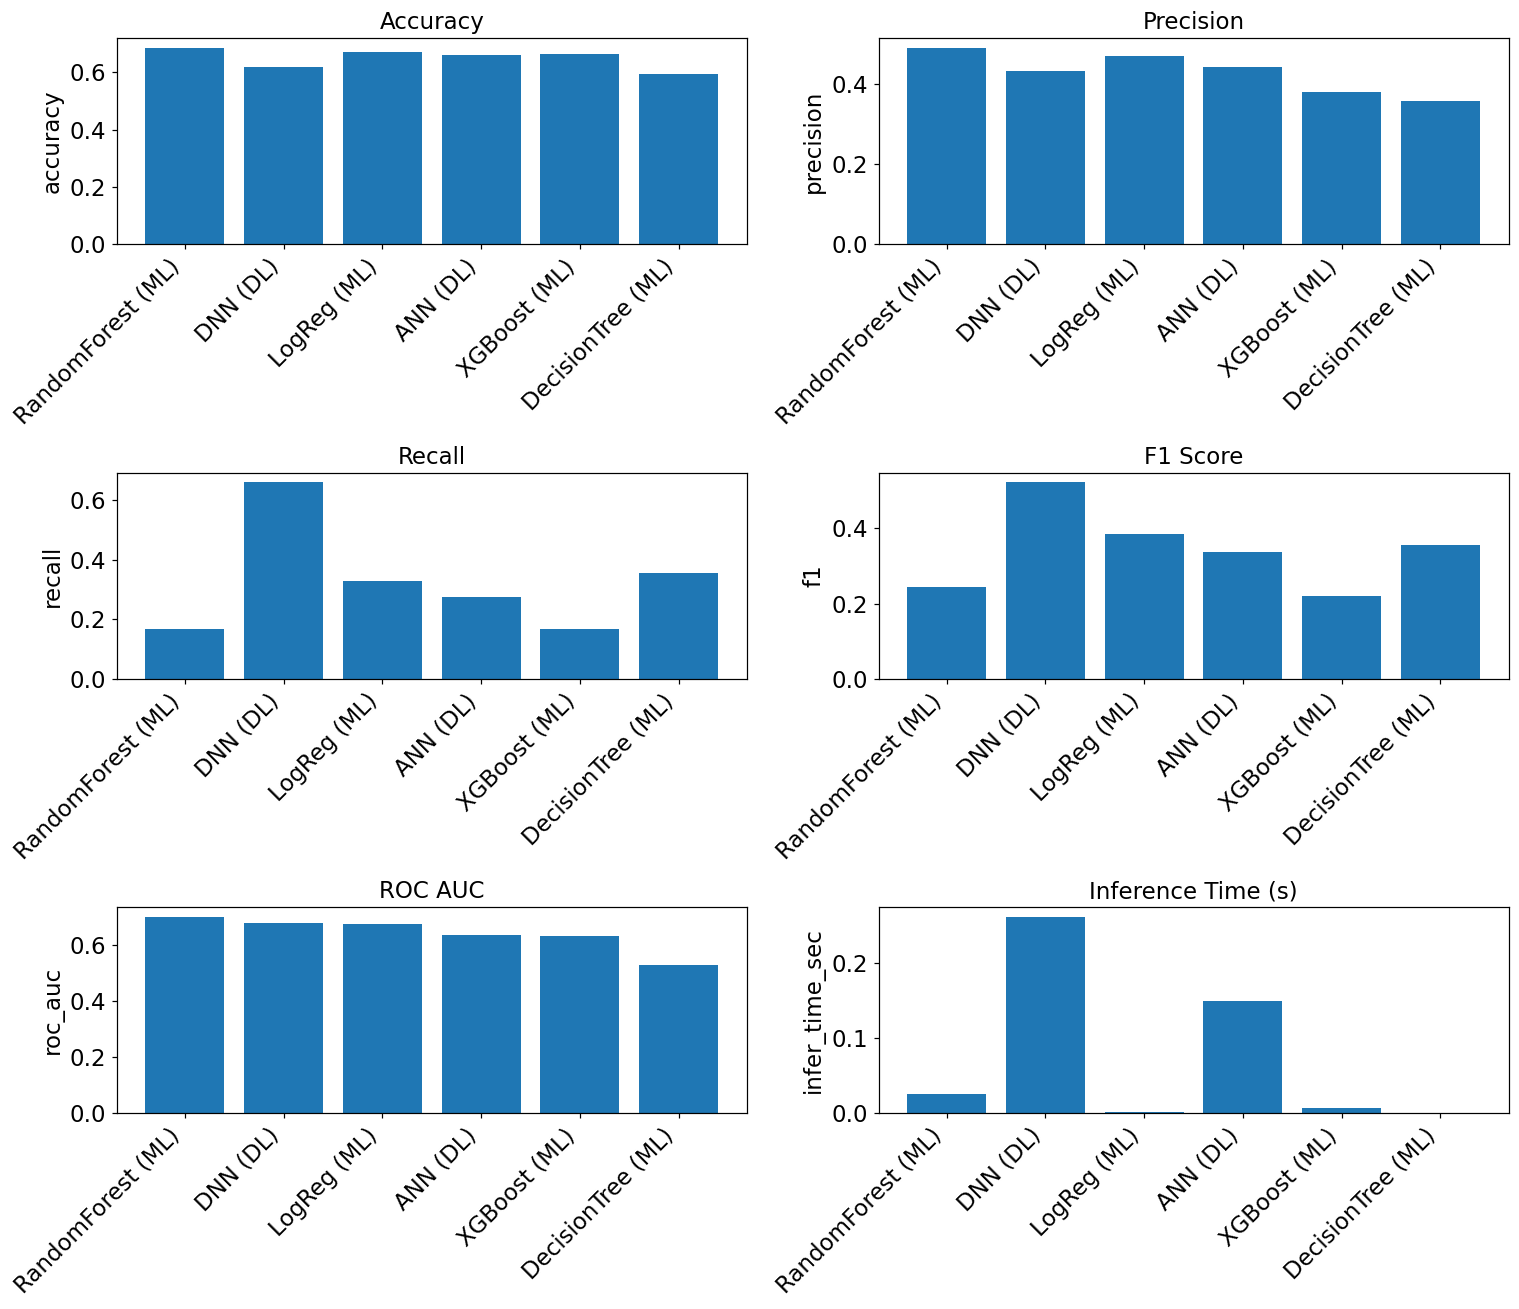

In [55]:
import matplotlib.pyplot as plt

metrics = ["accuracy","precision","recall","f1","roc_auc","infer_time_sec"]
titles  = ["Accuracy","Precision","Recall","F1 Score","ROC AUC","Inference Time (s)"]

n_cols, n_rows = 2, 3  # <-- your updated grid (2 columns, 3 rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 12))

# Font size scaling
base_size = 10
title_size = base_size * 1.5
label_size = base_size * 1.5
tick_size  = base_size * 1.5

for i, (metric, title) in enumerate(zip(metrics, titles)):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    vals = leaderboard[metric]
    labels = leaderboard["model"] + " (" + leaderboard["family"] + ")"
    ax.bar(labels, vals)
    ax.set_title(title, fontsize=title_size)
    ax.set_ylabel(metric, fontsize=label_size)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=tick_size)
    ax.tick_params(axis="y", labelsize=tick_size)

plt.tight_layout()
plt.show()


## 8.0 HYperparameter tuning

We will tune four ML models using three search strategies, with preprocessing done **inside each CV fold** to avoid leakage:

- Models: Logistic Regression (LR), Decision Tree (DT), Random Forest (RF), XGBoost (XGB)
- Searches: **GridSearchCV**, **RandomizedSearchCV**, **Optuna**
- Scoring: primary = **roc_auc** (you can switch to f1/recall later)
- CV: StratifiedKFold(k=5), shuffle=True, random_state=42

Implementation detail:
- We wrap each model with `LeakageSafeClassifier`, which:
  - Fits imputer+scaler (numeric), imputer+OHE (low-card categorical), **GroupTargetRateEncoder** (high-card) **only on the training split** it receives from the search CV.
  - Optionally applies **SMOTE** (set via constructor).

### 8.2 Parameter spaces (Grid & Random)

These are sensible, compact spaces. You can expand later if runtime allows.


In [58]:
from scipy.stats import randint, uniform, loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# LR
grid_lr = {
    "base_estimator__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "base_estimator__penalty": ["l2"],
    "base_estimator__solver": ["lbfgs", "saga"],
    "base_estimator__class_weight": [None, "balanced"],
    "oversampling": ["none", "smote"],
}
rand_lr = {
    "base_estimator__C": loguniform(1e-2, 1e1),
    "base_estimator__solver": ["lbfgs", "saga"],
    "base_estimator__class_weight": [None, "balanced"],
    "oversampling": ["none", "smote"],
}

# DT
grid_dt = {
    "base_estimator__max_depth": [None, 4, 6, 10, 14],
    "base_estimator__min_samples_split": [2, 5, 10, 20],
    "base_estimator__min_samples_leaf": [1, 2, 5, 10],
    "oversampling": ["none", "smote"],
}
rand_dt = {
    "base_estimator__max_depth": randint(3, 18),
    "base_estimator__min_samples_split": randint(2, 30),
    "base_estimator__min_samples_leaf": randint(1, 15),
    "oversampling": ["none", "smote"],
}

# RF
grid_rf = {
    "base_estimator__n_estimators": [200, 400, 600],
    "base_estimator__max_depth": [None, 6, 10, 16],
    "base_estimator__min_samples_split": [2, 5, 10],
    "base_estimator__min_samples_leaf": [1, 2, 5],
    "base_estimator__max_features": ["sqrt", "log2", None],
    "oversampling": ["none", "smote"],
}
rand_rf = {
    "base_estimator__n_estimators": randint(200, 800),
    "base_estimator__max_depth": randint(4, 24),
    "base_estimator__min_samples_split": randint(2, 20),
    "base_estimator__min_samples_leaf": randint(1, 10),
    "base_estimator__max_features": ["sqrt", "log2", None],
    "oversampling": ["none", "smote"],
}

# XGB (optional if xgboost installed)
try:
    from xgboost import XGBClassifier
    XGB_OK = True
    grid_xgb = {
        "base_estimator__n_estimators": [200, 400, 600],
        "base_estimator__max_depth": [3, 5, 7, 9],
        "base_estimator__learning_rate": [0.05, 0.1, 0.2],
        "base_estimator__subsample": [0.7, 0.85, 1.0],
        "base_estimator__colsample_bytree": [0.7, 0.85, 1.0],
        "base_estimator__reg_lambda": [0.0, 1.0, 5.0],
        "oversampling": ["none", "smote"],
    }
    rand_xgb = {
        "base_estimator__n_estimators": randint(150, 800),
        "base_estimator__max_depth": randint(3, 12),
        "base_estimator__learning_rate": loguniform(5e-3, 3e-1),
        "base_estimator__subsample": uniform(0.6, 0.4),          # 0.6–1.0
        "base_estimator__colsample_bytree": uniform(0.6, 0.4),   # 0.6–1.0
        "base_estimator__reg_lambda": loguniform(1e-3, 1e1),
        "oversampling": ["none", "smote"],
    }
except Exception:
    XGB_OK = False


### 8.3 Helpers to run searches and summarize results


In [60]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def run_grid_search(name, base_estimator, grid, X, y,
                    numeric_features, categorical_low, high_card_cols,
                    scoring="f1", n_splits=5, n_jobs=-1, verbose=1):
    wrapped = LeakageSafeClassifier(
        base_estimator=base_estimator,
        numeric_features=numeric_features,
        categorical_low=categorical_low,
        high_card_cols=high_card_cols,
        oversampling="none",  # grid can override via param
        random_state=42
    )
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    gs = GridSearchCV(
        estimator=wrapped,
        param_grid=grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        refit=True
    )
    gs.fit(X, y)
    print(f"[Grid] {name} best: {gs.best_score_:.4f} with params: {gs.best_params_}")
    return gs

def run_random_search(name, base_estimator, dist, X, y,
                      numeric_features, categorical_low, high_card_cols,
                      scoring="f1", n_splits=5, n_iter=40, n_jobs=-1, verbose=1):
    wrapped = LeakageSafeClassifier(
        base_estimator=base_estimator,
        numeric_features=numeric_features,
        categorical_low=categorical_low,
        high_card_cols=high_card_cols,
        oversampling="none",
        random_state=42
    )
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rs = RandomizedSearchCV(
        estimator=wrapped,
        param_distributions=dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        refit=True,
        random_state=42
    )
    rs.fit(X, y)
    print(f"[Random] {name} best: {rs.best_score_:.4f} with params: {rs.best_params_}")
    return rs


### 8.4 Run Grid & Random on all four models

In [62]:
# Recompute feature partitions (in case session restarted)
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
HIGH_CARD_COLS = [c for c in ["Branch","Region"] if c in X_train.columns]
categorical_low = [c for c in categorical_features if c not in HIGH_CARD_COLS]

search_results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000, n_jobs=None)
search_results["LR_grid"]  = run_grid_search("LR", lr, grid_lr, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)
search_results["LR_rand"]  = run_random_search("LR", lr, rand_lr, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
search_results["DT_grid"]  = run_grid_search("DT", dt, grid_dt, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)
search_results["DT_rand"]  = run_random_search("DT", dt, rand_dt, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
search_results["RF_grid"]  = run_grid_search("RF", rf, grid_rf, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)
search_results["RF_rand"]  = run_random_search("RF", rf, rand_rf, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)

# XGBoost (if available)
if XGB_OK:
    xgb = XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric="logloss",
        tree_method="hist"  # fast default
    )
    search_results["XGB_grid"] = run_grid_search("XGB", xgb, grid_xgb, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)
    search_results["XGB_rand"] = run_random_search("XGB", xgb, rand_xgb, X_train, y_train, numeric_features, categorical_low, HIGH_CARD_COLS)
else:
    print("ℹ️ xgboost not installed — skipping XGB searches.")


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[Grid] LR best: 0.5270 with params: {'base_estimator__C': 0.1, 'base_estimator__class_weight': 'balanced', 'base_estimator__penalty': 'l2', 'base_estimator__solver': 'lbfgs', 'oversampling': 'none'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[Random] LR best: 0.5392 with params: {'base_estimator__C': 0.021511587551819603, 'base_estimator__class_weight': 'balanced', 'base_estimator__solver': 'lbfgs', 'oversampling': 'none'}
Fitting 5 folds for each of 160 candidates, totalling 800 fits
[Grid] DT best: 0.4066 with params: {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 10, 'base_estimator__min_samples_split': 2, 'oversampling': 'none'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Random] DT best: 0.4047 with params: {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 10, 'base_estimator__min_samples_split': 26, 'oversampling': 'smote'}
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[Grid] RF best: 0.4315 with params: {'base_estimator__max_depth': 6, 'base_estimator__max_features': 'log2', 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 600, 'oversampling': 'smote'}
Fitting 5 folds for ea

### 8.5 Optuna — unified objective for each model

- Optimizes **f1** via 5-fold StratifiedKFold.
- Early stopping/pruning enabled by Optuna.
- Search spaces mirror (and slightly extend) the random search distributions.


In [64]:
# === Optuna objective for F1 instead of ROC-AUC ===
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

def optuna_objective_f1(model_name, X, y, numeric_features, categorical_low, high_card_cols, trial):
    """Return mean cross-validated F1 score (binary) for the given model."""
    if model_name == "LR":
        C = trial.suggest_float("C", 1e-2, 10.0, log=True)
        solver = trial.suggest_categorical("solver", ["lbfgs", "saga"])
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
        overs = trial.suggest_categorical("oversampling", ["none", "smote"])
        base = LogisticRegression(max_iter=2000, penalty="l2", C=C,
                                  solver=solver, class_weight=class_weight)

    elif model_name == "DT":
        max_depth = trial.suggest_int("max_depth", 3, 24)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
        overs = trial.suggest_categorical("oversampling", ["none", "smote"])
        base = DecisionTreeClassifier(random_state=42,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf)

    elif model_name == "RF":
        n_estimators = trial.suggest_int("n_estimators", 200, 900, step=50)
        max_depth = trial.suggest_int("max_depth", 4, 24)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        overs = trial.suggest_categorical("oversampling", ["none", "smote"])
        base = RandomForestClassifier(random_state=42, n_jobs=-1,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features)

    elif model_name == "XGB" and XGB_OK:
        pos = (y == 1).sum()
        neg = (y == 0).sum()
        base_ratio = (neg / max(1, pos)) if pos > 0 else 1.0
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 250, 1000, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 5e-3, 3e-1, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 1.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 20.0, log=True),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5*base_ratio, 2.0*base_ratio),
        }
        overs = trial.suggest_categorical("oversampling", ["none", "smote"])
        base = XGBClassifier(random_state=42, n_jobs=-1, eval_metric="logloss",
                             tree_method="hist", **params)
    else:
        raise ValueError("Unknown model or XGB not available.")

    # ---- wrap with leakage-safe pipeline (handles per-fold preprocessing & optional SMOTE) ----
    wrapped = LeakageSafeClassifier(
        base_estimator=base,
        numeric_features=numeric_features,
        categorical_low=categorical_low,
        high_card_cols=high_card_cols,
        oversampling=overs,
        random_state=42
    )

    # ---- 5-fold CV returning mean F1 ----
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for i, (tr, va) in enumerate(skf.split(X, y)):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        wrapped.fit(X_tr, y_tr)
        y_pred = wrapped.predict(X_va)
        try:
            scores.append(f1_score(y_va, y_pred))
        except Exception:
            scores.append(np.nan)
        trial.report(np.nanmean(scores), i + 1)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return float(np.nanmean(scores))

### 8.6 Run Optuna for all 4 models


In [66]:
# ---- Run Optuna searches ----
# optuna_results = {}
# for name in ["LR", "DT", "RF"] + (["XGB"] if XGB_OK else []):
#     study = optuna.create_study(direction="maximize", study_name=f"{name}_roc_auc")
#     study.optimize(lambda tr: optuna_objective(
#         name, X_train, y_train,
#         numeric_features=X_train.select_dtypes(include=["int64","float64"]).columns.tolist(),
#         categorical_low=[c for c in X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
#                          if c not in [col for col in ["Branch", "Region"] if col in X_train.columns]],
#         high_card_cols=[col for col in ["Branch", "Region"] if col in X_train.columns],
#         trial=tr
#     ), n_trials=40, gc_after_trial=True)
#     print(f"[Optuna] {name}: best AUC={study.best_value:.4f} | best params: {study.best_params}")
#     optuna_results[name] = study

# ---- Run Optuna searches, now optimizing F1 instead of ROC-AUC ----

# ---- Run studies for F1 ----
optuna_results_f1 = {}
for name in ["LR", "DT", "RF"] + (["XGB"] if XGB_OK else []):
    study = optuna.create_study(direction="maximize", study_name=f"{name}_f1")
    study.optimize(lambda tr: optuna_objective_f1(
        name, X_train, y_train,
        numeric_features=X_train.select_dtypes(include=["int64","float64"]).columns.tolist(),
        categorical_low=[c for c in X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
                         if c not in [col for col in ["Branch", "Region"] if col in X_train.columns]],
        high_card_cols=[col for col in ["Branch", "Region"] if col in X_train.columns],
        trial=tr
    ), n_trials=40, gc_after_trial=True)
    print(f"[Optuna-F1] {name}: best F1={study.best_value:.4f} | best params: {study.best_params}")
    optuna_results_f1[name] = study

[I 2025-11-29 15:12:47,658] A new study created in memory with name: LR_f1
[I 2025-11-29 15:12:50,033] Trial 0 finished with value: 0.5347563120143446 and parameters: {'C': 0.031087173169513146, 'solver': 'saga', 'class_weight': 'balanced', 'oversampling': 'none'}. Best is trial 0 with value: 0.5347563120143446.
[I 2025-11-29 15:12:52,052] Trial 1 finished with value: 0.3714400530027864 and parameters: {'C': 1.6459421374340684, 'solver': 'lbfgs', 'class_weight': 'balanced', 'oversampling': 'none'}. Best is trial 0 with value: 0.5347563120143446.
[I 2025-11-29 15:12:52,790] Trial 2 finished with value: 0.33209080272043706 and parameters: {'C': 0.22259327465166417, 'solver': 'lbfgs', 'class_weight': None, 'oversampling': 'none'}. Best is trial 0 with value: 0.5347563120143446.
[I 2025-11-29 15:12:54,996] Trial 3 finished with value: 0.28624230297410225 and parameters: {'C': 0.4575809861221482, 'solver': 'lbfgs', 'class_weight': None, 'oversampling': 'none'}. Best is trial 0 with value: 0

[Optuna-F1] LR: best F1=0.5406 | best params: {'C': 0.015043253762721224, 'solver': 'lbfgs', 'class_weight': 'balanced', 'oversampling': 'none'}


[I 2025-11-29 15:13:36,884] Trial 0 finished with value: 0.2913007520779084 and parameters: {'max_depth': 21, 'min_samples_split': 27, 'min_samples_leaf': 7, 'oversampling': 'none'}. Best is trial 0 with value: 0.2913007520779084.
[I 2025-11-29 15:13:37,433] Trial 1 finished with value: 0.39958034410721205 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 5, 'oversampling': 'smote'}. Best is trial 1 with value: 0.39958034410721205.
[I 2025-11-29 15:13:38,096] Trial 2 finished with value: 0.3676996128126365 and parameters: {'max_depth': 17, 'min_samples_split': 27, 'min_samples_leaf': 3, 'oversampling': 'smote'}. Best is trial 1 with value: 0.39958034410721205.
[I 2025-11-29 15:13:38,513] Trial 3 finished with value: 0.3509760645487042 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'oversampling': 'none'}. Best is trial 1 with value: 0.39958034410721205.
[I 2025-11-29 15:13:38,923] Trial 4 finished with value: 0.36082148210940

[Optuna-F1] DT: best F1=0.3996 | best params: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 5, 'oversampling': 'smote'}


[I 2025-11-29 15:13:55,128] Trial 0 finished with value: 0.1999579306224512 and parameters: {'n_estimators': 500, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2', 'oversampling': 'none'}. Best is trial 0 with value: 0.1999579306224512.
[I 2025-11-29 15:14:13,203] Trial 1 finished with value: 0.327244299987605 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None, 'oversampling': 'smote'}. Best is trial 1 with value: 0.327244299987605.
[I 2025-11-29 15:14:20,109] Trial 2 finished with value: 0.24644098831274258 and parameters: {'n_estimators': 700, 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'oversampling': 'smote'}. Best is trial 1 with value: 0.327244299987605.
[I 2025-11-29 15:14:23,113] Trial 3 finished with value: 0.30123359323960114 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf

[Optuna-F1] RF: best F1=0.3628 | best params: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'oversampling': 'smote'}


[I 2025-11-29 15:19:08,612] Trial 0 finished with value: 0.28000897547504977 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.040575493512602305, 'subsample': 0.7375209526722588, 'colsample_bytree': 0.8679201563377202, 'min_child_weight': 14.057004206401114, 'gamma': 3.6026789667159957, 'reg_alpha': 0.12870426428257484, 'reg_lambda': 0.011805681784046198, 'scale_pos_weight': 2.7979809461022636, 'oversampling': 'none'}. Best is trial 0 with value: 0.28000897547504977.
[I 2025-11-29 15:19:09,832] Trial 1 finished with value: 0.2807730297140201 and parameters: {'n_estimators': 850, 'max_depth': 6, 'learning_rate': 0.26050741844239983, 'subsample': 0.9130969034600244, 'colsample_bytree': 0.7860103472424759, 'min_child_weight': 19.75918447804532, 'gamma': 4.298720368277587, 'reg_alpha': 0.08749398631884582, 'reg_lambda': 3.7161990491330283, 'scale_pos_weight': 2.8758464593726885, 'oversampling': 'none'}. Best is trial 1 with value: 0.2807730297140201.
[I 2025-11-29 1

[Optuna-F1] XGB: best F1=0.3633 | best params: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.017419632517418862, 'subsample': 0.9099590099165629, 'colsample_bytree': 0.6771797950790309, 'min_child_weight': 12.734324533980867, 'gamma': 1.7141412164805763, 'reg_alpha': 0.012267838389062584, 'reg_lambda': 1.468003036715056, 'scale_pos_weight': 4.093178104332196, 'oversampling': 'smote'}


In [67]:
def evaluate_models_cv_any(
    models: dict,
    X: pd.DataFrame,
    y: pd.Series,
    numeric_features: list,
    categorical_low: list,
    high_card_cols: list,
    n_splits: int = 5,
    oversampling: str = "none",
    random_state: int = 42
):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    import numpy as np, time

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []

    for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
        y_tr, y_va = y.iloc[tr_idx].copy(), y.iloc[va_idx].copy()

        # Outer preprocessors for plain models
        pre = fit_fold_preprocessors(X_tr, y_tr, numeric_features, categorical_low, high_card_cols)
        Xtr_mat, _ = transform_with_preprocessors(pre, X_tr, numeric_features, categorical_low, high_card_cols)
        Xva_mat, _ = transform_with_preprocessors(pre, X_va, numeric_features, categorical_low, high_card_cols)

        for name, est in models.items():
            is_wrapped = est.__class__.__name__ == "LeakageSafeClassifier"

            if is_wrapped:
                t0 = time.perf_counter(); est.fit(X_tr, y_tr); train_time = time.perf_counter() - t0
                t1 = time.perf_counter(); y_pred = est.predict(X_va); infer_time = time.perf_counter() - t1
                y_score = est.predict_proba(X_va)[:, 1] if hasattr(est, "predict_proba") else y_pred
            else:
                Xtr_use, ytr_use = Xtr_mat, y_tr
                if oversampling.lower() == "smote" and IMB_AVAILABLE:
                    sm = SMOTE(random_state=random_state); Xtr_use, ytr_use = sm.fit_resample(Xtr_use, ytr_use)
                t0 = time.perf_counter(); est.fit(Xtr_use, ytr_use); train_time = time.perf_counter() - t0
                t1 = time.perf_counter(); y_pred = est.predict(Xva_mat); infer_time = time.perf_counter() - t1
                y_score = est.predict_proba(Xva_mat)[:, 1] if hasattr(est, "predict_proba") else y_pred

            try: auc = roc_auc_score(y_va, y_score)
            except Exception: auc = np.nan

            rows.append({
                "fold": fold_idx, "model": name,
                "accuracy": accuracy_score(y_va, y_pred),
                "precision": precision_score(y_va, y_pred, zero_division=0),
                "recall": recall_score(y_va, y_pred, zero_division=0),
                "f1": f1_score(y_va, y_pred, zero_division=0),
                "roc_auc": auc,
                "train_time_sec": train_time,
                "infer_time_sec": infer_time
            })

    per_fold_df = pd.DataFrame(rows)
    summary = (per_fold_df.groupby("model", as_index=False)
               .agg({"accuracy":"mean","precision":"mean","recall":"mean","f1":"mean","roc_auc":"mean",
                     "train_time_sec":"mean","infer_time_sec":"mean"})
               .sort_values(["roc_auc","f1","recall"], ascending=False)
               .reset_index(drop=True))
    return per_fold_df, summary

### 8.7 Collect Best Models & Compare

This cell pulls the **best estimator** from each search run, evaluates with the same 5-fold CV harness you used earlier, and prints a mini-leaderboard of tuned models.


In [69]:
# Expecting you already have `search_results` from 8.4 (Grid/Random). If not, set it to {}.
try:
    search_results
except NameError:
    search_results = {}

# Recompute feature partitions (safe)
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
HIGH_CARD_COLS = [c for c in ["Branch","Region"] if c in X_train.columns]
categorical_low = [c for c in categorical_features if c not in HIGH_CARD_COLS]

tuned_models = {}

# 8.7.1 — add best estimators from Grid/Random (already wrapped LeakageSafeClassifier via Grid/Random)
for key, res in search_results.items():
    tuned_models[f"{key}"] = res.best_estimator_

# 8.7.2 — add Optuna-best as new wrapped models (build from study.best_params)
def build_optuna_best(name, study):
    params = study.best_params
    overs = params.get("oversampling", "none")

    if name == "LR":
        base = LogisticRegression(max_iter=2000, penalty="l2",
                                  C=params["C"], solver=params["solver"],
                                  class_weight=params["class_weight"])
    elif name == "DT":
        base = DecisionTreeClassifier(random_state=42,
                                      max_depth=params["max_depth"],
                                      min_samples_split=params["min_samples_split"],
                                      min_samples_leaf=params["min_samples_leaf"])
    elif name == "RF":
        base = RandomForestClassifier(random_state=42, n_jobs=-1,
                                      n_estimators=params["n_estimators"],
                                      max_depth=params["max_depth"],
                                      min_samples_split=params["min_samples_split"],
                                      min_samples_leaf=params["min_samples_leaf"],
                                      max_features=params["max_features"])
    # elif name == "XGB" and XGB_OK:
    #     base = XGBClassifier(
    #         n_estimators=params["n_estimators"],
    #         max_depth=params["max_depth"],
    #         learning_rate=params["learning_rate"],
    #         subsample=params["subsample"],
    #         colsample_bytree=params["colsample_bytree"],
    #         reg_lambda=params["reg_lambda"],
    #         random_state=42, n_jobs=-1, eval_metric="logloss", tree_method="hist"
    #     )
    # ==== F2. 8.7 build_optuna_best — XGB case ====
    elif name == "XGB" and XGB_OK:
        base = XGBClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        min_child_weight=params["min_child_weight"],
        gamma=params["gamma"],
        reg_alpha=params["reg_alpha"],
        reg_lambda=params["reg_lambda"],
        scale_pos_weight=params["scale_pos_weight"],
        random_state=RANDOM_STATE, n_jobs=-1, eval_metric="logloss", tree_method="hist"
        )
    else:
        return None

    return LeakageSafeClassifier(
        base_estimator=base,
        numeric_features=numeric_features,
        categorical_low=categorical_low,
        high_card_cols=HIGH_CARD_COLS,
        oversampling=overs,
        random_state=42
    )

for name, study in optuna_results_f1.items():
    est = build_optuna_best(name, study)
    if est is not None:
        tuned_models[f"{name}_optuna"] = est

# 8.7.3 — Evaluate tuned models with the flexible evaluator
tuned_rows = []
for name, est in tuned_models.items():
    per_fold, summary = evaluate_models_cv_any(
        models={name: est},
        X=X_train, y=y_train,
        numeric_features=numeric_features,
        categorical_low=categorical_low,
        high_card_cols=HIGH_CARD_COLS,
        n_splits=5,
        oversampling="none",
        random_state=42
    )
    summary["search"] = name
    tuned_rows.append(summary)

tuned_leaderboard = (pd.concat(tuned_rows, ignore_index=True)
                     .sort_values(["roc_auc","f1","recall"], ascending=False)
                     .reset_index(drop=True))

print("Tuned models leaderboard:")
display(tuned_leaderboard)


Tuned models leaderboard:


,model,accuracy,precision,recall,f1,roc_auc,train_time_sec,infer_time_sec,search
0,RF_rand,0.69025,0.507953,0.405350,0.444194,0.720325,0.472564,0.029560,RF_rand
1,RF_grid,0.69150,0.513791,0.384006,0.431511,0.716276,0.772592,0.044521,RF_grid
2,RF_optuna,0.68825,0.507050,0.293147,0.362776,0.710087,0.378871,0.026895,RF_optuna
3,LR_optuna,0.65175,0.464101,0.647711,0.540649,0.708268,0.213113,0.007473,LR_optuna
4,LR_rand,0.65100,0.463189,0.645339,0.539229,0.707884,0.086457,0.005403,LR_rand
5,LR_grid,0.65450,0.465561,0.607426,0.526976,0.705523,0.090788,0.007237,LR_grid
6,XGB_optuna,0.60150,0.361695,0.516162,0.363273,0.672974,0.257184,0.004544,XGB_optuna
7,XGB_rand,0.65250,0.375742,0.273484,0.287826,0.656872,1.816249,0.011142,XGB_rand
8,XGB_grid,0.65150,0.390096,0.309841,0.305727,0.624240,0.267405,0.004474,XGB_grid
9,DT_rand,0.60125,0.385900,0.446391,0.404656,0.581754,0.087266,0.003371,DT_rand


In [70]:
# === 8.x.2 Rank-averaging ensemble: LR + RF + XGB ===
from sklearn.model_selection import StratifiedKFold
import time

def sigmoid_score(y):
    # utility to map any decision_function output to [0,1] if needed
    if y.ndim == 1:
        y = (y - y.min()) / (y.max() - y.min() + 1e-9)
    return y

def evaluate_rank_ensemble_cv(
    X, y, n_splits=5, random_state=RANDOM_STATE,
    lr_params=None, rf_params=None, xgb_params=None
):
    # Defaults (replace with your tuned params if you want)
    if lr_params is None:
        lr_params = dict(C=1.0, solver="lbfgs", max_iter=2000, class_weight=None)
    if rf_params is None:
        rf_params = dict(n_estimators=400, max_depth=None, min_samples_split=2,
                         min_samples_leaf=1, n_jobs=-1, random_state=random_state)
    if xgb_params is None:
        from xgboost import XGBClassifier
        xgb_params = dict(n_estimators=600, max_depth=6, learning_rate=0.05,
                          subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                          tree_method="hist", eval_metric="logloss",
                          n_jobs=-1, random_state=random_state)

    models = {
        "LR": LeakageSafeClassifier(
            base_estimator=LogisticRegression(**lr_params),
            numeric_features=numeric_features, categorical_low=categorical_low,
            high_card_cols=HIGH_CARD_COLS, oversampling="smote", random_state=random_state),
        "RF": LeakageSafeClassifier(
            base_estimator=RandomForestClassifier(**rf_params),
            numeric_features=numeric_features, categorical_low=categorical_low,
            high_card_cols=HIGH_CARD_COLS, oversampling="smote", random_state=random_state),
    }

    # XGBoost might be unavailable in some envs
    try:
        from xgboost import XGBClassifier
        models["XGB"] = LeakageSafeClassifier(
            base_estimator=XGBClassifier(**xgb_params),
            numeric_features=numeric_features, categorical_low=categorical_low,
            high_card_cols=HIGH_CARD_COLS, oversampling="smote", random_state=random_state)
    except Exception:
        pass

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []
    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        # Fit each model on the fold, get validation probabilities
        preds = []
        for name, est in models.items():
            est.fit(X_tr, y_tr)
            p = est.predict_proba(X_va)[:, 1]
            # rank-normalize each model's probabilities (robust for AUC)
            rank = pd.Series(p).rank(method="average", pct=True).to_numpy()
            preds.append(rank)

        # rank-average ensemble
        P_ens = np.mean(np.column_stack(preds), axis=1)

        rows.append({
            "fold": fold,
            "model": "RankEnsemble(LR+RF+XGB)",
            "roc_auc": roc_auc_score(y_va, P_ens),
            "accuracy": accuracy_score(y_va, (P_ens>=0.5).astype(int)),
            "precision": precision_score(y_va, (P_ens>=0.5).astype(int), zero_division=0),
            "recall": recall_score(y_va, (P_ens>=0.5).astype(int), zero_division=0),
            "f1": f1_score(y_va, (P_ens>=0.5).astype(int), zero_division=0),
        })
    df_ens = pd.DataFrame(rows)
    print("Rank-averaged ensemble CV:")
    display(df_ens.agg({"roc_auc":"mean","accuracy":"mean","precision":"mean",
                        "recall":"mean","f1":"mean"}).to_frame("mean").T)
    return df_ens

# Run:
ens_per_fold = evaluate_rank_ensemble_cv(X_train, y_train, n_splits=5)

Rank-averaged ensemble CV:


,roc_auc,accuracy,precision,recall,f1
mean,0.686732,0.61275,0.432072,0.708546,0.536779


### 8.8 Side-by-side comparison of baseline vs tuned

In [72]:
import pandas as pd
import numpy as np 

# Inputs expected from earlier sections:
# leaderboard (baseline ML+DL), tuned_leaderboard (tuned ML)
# Ensure these variables exist in your environment before running this.
if "leaderboard" not in globals() or "tuned_leaderboard" not in globals():
    print("WARNING: 'leaderboard' or 'tuned_leaderboard' dataframes are missing. Please run previous sections first.")
else:
    MODEL_ORDER = ["LogReg", "DecisionTree", "RandomForest", "XGBoost", "ANN", "DNN"]
    METRICS_ALL = ["accuracy", "precision", "recall", "f1", "roc_auc", "train_time_sec", "infer_time_sec"]
    METHOD_ORDER = ["Baseline", "Random Search", "Grid Search", "Optuna"]

    # --- 1) Baseline rows (from Section 7)
    base_cols = ["model", "family"] + METRICS_ALL
    baseline_rows = []
    
    # FIXED: Removed the stray backtick ` at the end of this line
    for _, r in leaderboard[base_cols].iterrows():
        baseline_rows.append({
            "model": r["model"],
            "family": r["family"],
            "method": "Baseline",
            **{m: r.get(m, float("nan")) for m in METRICS_ALL}
        })
    baseline_df = pd.DataFrame(baseline_rows)

    # --- 2) Tuned rows (from Section 8.7; ML only)
    def parse_search_name(name: str):
        if   name.startswith("LR_"):  model = "LogReg"
        elif name.startswith("DT_"):  model = "DecisionTree"
        elif name.startswith("RF_"):  model = "RandomForest"
        elif name.startswith("XGB_"): model = "XGBoost"
        else:                         model = name
        
        if   name.endswith("_grid"):   method = "Grid Search"
        elif name.endswith("_rand"):   method = "Random Search"
        elif name.endswith("_optuna"): method = "Optuna"
        else:                          method = "Baseline"
        return model, method

    tuned_rows = []
    need_cols = ["search"] + METRICS_ALL
    for _, r in tuned_leaderboard[need_cols].iterrows():
        model, method = parse_search_name(r["search"])
        tuned_rows.append({
            "model": model,
            "family": "ML",
            "method": method,
            **{m: r.get(m, float("nan")) for m in METRICS_ALL}
        })
    tuned_df = pd.DataFrame(tuned_rows)

    # --- 3) Combine, order, and pivot
    combo = pd.concat([baseline_df, tuned_df], ignore_index=True)
    combo = combo[combo["model"].isin(MODEL_ORDER)].copy()

    combo["model"]  = pd.Categorical(combo["model"], categories=MODEL_ORDER, ordered=True)
    combo["method"] = pd.Categorical(combo["method"], categories=METHOD_ORDER, ordered=True)
    combo = combo.sort_values(["model", "method"]).reset_index(drop=True)

    comparison_pivot = combo.pivot_table(
        index=["model", "method"],
        values=METRICS_ALL,
        aggfunc="first",
        observed=False
    )

    # Drop rows that are entirely NaN
    comparison_pivot = comparison_pivot.dropna(how="all")

    # Ensure column order
    comparison_pivot = comparison_pivot[METRICS_ALL]

    # --- 4) Styler: highlight exactly ONE best cell per column
    def style_global_best(df: pd.DataFrame):
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        for col in df.columns:
            series = df[col].astype(float)
            if series.notna().sum() == 0:
                continue
            if col in ("train_time_sec", "infer_time_sec"):
                idx = series.idxmin()   # lower is better for time
            else:
                idx = series.idxmax()   # higher is better for metrics
            styles.loc[idx, col] = 'font-weight: bold; background-color: #e6f2ff;' # Added light blue bg for visibility
        return styles

    # --- Add outlines to pivot table
    def style_with_full_borders(df: pd.DataFrame):
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        
        # Thin grey grid for all data cells
        styles[:] = 'border: 1px solid #d3d3d3;' 

        # Thicker border above each model block
        # We iterate through the unique models actually present in the index
        present_models = df.index.get_level_values(0).unique()
        
        for model in present_models:
            try:
                # Find the first method/row for this model
                first_idx = df.loc[model].index[0]
                full_idx = (model, first_idx)
                
                # Apply top border
                current_style = styles.loc[full_idx, :]
                styles.loc[full_idx, :] = [s + 'border-top: 2px solid black;' for s in current_style]
            except KeyError:
                continue

        return styles

    # Format: 4 d.p. for metrics, 3 d.p. for times
    fmt = {m: "{:.4f}" for m in ["accuracy", "precision", "recall", "f1", "roc_auc"]}
    fmt.update({"train_time_sec": "{:.3f}", "infer_time_sec": "{:.3f}"})

    styled = (comparison_pivot
              .style
              .apply(style_global_best, axis=None)     
              .apply(style_with_full_borders, axis=None)  
              .set_table_styles([
                  {"selector": "th", "props": [("border", "1px solid black"), ("background-color", "#f2f2f2")]}, 
                  {"selector": "td", "props": [("border", "1px solid #d3d3d3")]}
              ])
              .format(fmt))

print("Baseline vs Tuned — compact pivot (rows: Model → Method; columns: metrics incl. time):")
styled

Baseline vs Tuned — compact pivot (rows: Model → Method; columns: metrics incl. time):


_Observation_:
- LogReg-Optuna and DNN are the only two with F1 > 0.54.
- DNN favors recall heavily (good for churn), but has moderate precision.
- LogReg-Optuna has more balanced precision (0.46) and recall (0.65) while maintaining a high AUC (0.7083).

*Most balanced model overall:*
- Logistic Regression (Optuna-tuned). It gives the best compromise between precision, recall, F1, and AUC, and is also simple, interpretable, and SHAP-friendly.

### 8.9 ROC curves for all models

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(models_dict, X_test, y_test):
    """
    models_dict: dict(model_name -> fitted_model)
    X_test: raw test features (DataFrame)
    y_test: test target (Series)
    """
    plt.figure(figsize=(10, 8))
    
    # Store results to sort legend
    results = []

    for name, model in models_dict.items():
        # Predict probability (handle both sklearn & Keras models)
        try:
            # This works for LeakageSafeClassifier
            y_prob = model.predict_proba(X_test)[:, 1]
        except Exception as e:
            print(f"Could not get predict_proba for {name}, trying .predict(). Error: {e}")
            try:
                y_prob = model.predict(X_test).ravel()  # for ANN/DNN if they were here
            except Exception as e2:
                print(f"Failed to get any prediction for {name}. Error: {e2}")
                continue

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results.append((roc_auc, fpr, tpr, name))

    # Sort by AUC for a cleaner legend
    results.sort(key=lambda x: x[0], reverse=True)
    
    for roc_auc, fpr, tpr, name in results:
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Chance (AUC = 0.500)")

    plt.title("ROC Curves for Tuned Models (on Test Set)", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Found 12 tuned ML models from Section 8.8.
Fitting best tuned ML models on full X_train...
... Fitting LR_grid
    -> Done in 0.11s
... Fitting LR_rand
    -> Done in 0.10s
... Fitting DT_grid
    -> Done in 0.14s
... Fitting DT_rand
    -> Done in 0.19s
... Fitting RF_grid
    -> Done in 0.95s
... Fitting RF_rand
    -> Done in 0.60s
... Fitting XGB_grid
    -> Done in 0.30s
... Fitting XGB_rand
    -> Done in 2.20s
... Fitting LR_optuna
    -> Done in 0.07s
... Fitting DT_optuna
    -> Done in 0.17s
... Fitting RF_optuna
    -> Done in 0.53s
... Fitting XGB_optuna
    -> Done in 0.31s

Generating ROC curves on X_test...


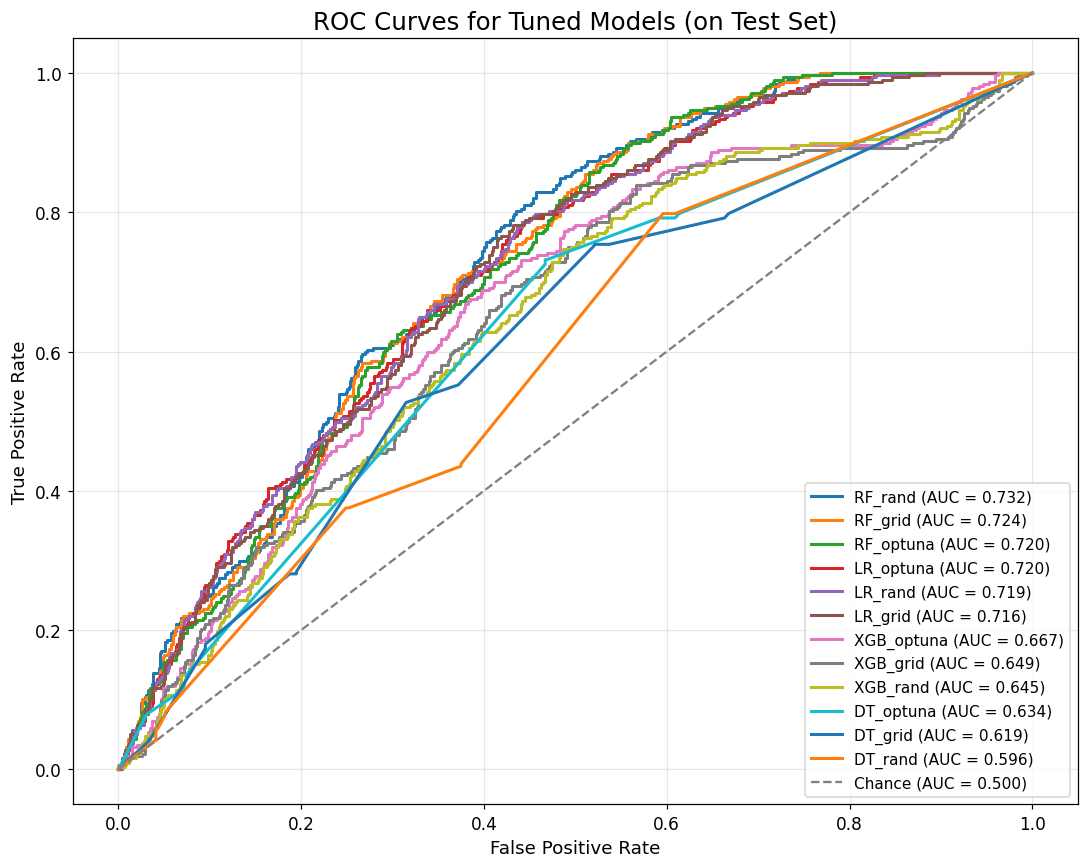

In [75]:
import time

# This dict 'tuned_models' was created in cell [154]
# It contains the *unfitted* LeakageSafeClassifier instances with the best parameters.
# We must fit them all on the full X_train before plotting.

print(f"Found {len(tuned_models)} tuned ML models from Section 8.8.")
print("Fitting best tuned ML models on full X_train...")

fitted_ml_models = {}

for name, model in tuned_models.items():
    print(f"... Fitting {name}")
    t0 = time.time()
    
    # Fit the model on the *entire* X_train to get a final version
    # The LeakageSafeClassifier handles all internal preprocessing and oversampling
    model.fit(X_train, y_train)
    
    fitted_ml_models[name] = model
    print(f"    -> Done in {time.time() - t0:.2f}s")

print("\nGenerating ROC curves on X_test...")
# X_test is the raw test set; the LeakageSafeClassifier wrapper handles all preprocessing
plot_roc_curves(fitted_ml_models, X_test, y_test)

### 8.10 Confusion matrices for all models

Generating predictions from fitted ML models...
  Getting predictions for Log Reg - Random Search...
  Getting predictions for Decision Tree - Optuna...
  Getting predictions for Random Forest - Grid Search...
  Getting predictions for XGBoost - Optuna...

Preprocessing data for DL models...

Training DL models with baseline procedure...
  Training ANN - Baseline...


E0000 00:00:1764405133.748449 18776454 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


  Training DNN - Baseline...

Generating confusion matrices...

Log Reg - Random Search:
  Confusion Matrix: TN=449, FP=234, FN=108, TP=209
  Accuracy: 0.6580, Precision: 0.4718, Recall: 0.6593, F1: 0.5500
Decision Tree - Optuna:
  Confusion Matrix: TN=364, FP=319, FN=87, TP=230
  Accuracy: 0.5940, Precision: 0.4189, Recall: 0.7256, F1: 0.5312
Random Forest - Grid Search:
  Confusion Matrix: TN=601, FP=82, FN=233, TP=84
  Accuracy: 0.6850, Precision: 0.5060, Recall: 0.2650, F1: 0.3478
XGBoost - Optuna:
  Confusion Matrix: TN=348, FP=335, FN=72, TP=245
  Accuracy: 0.5930, Precision: 0.4224, Recall: 0.7729, F1: 0.5463
DNN - Baseline:
  Confusion Matrix: TN=390, FP=293, FN=84, TP=233
  Accuracy: 0.6230, Precision: 0.4430, Recall: 0.7350, F1: 0.5528
ANN - Baseline:
  Confusion Matrix: TN=555, FP=128, FN=208, TP=109
  Accuracy: 0.6640, Precision: 0.4599, Recall: 0.3438, F1: 0.3935


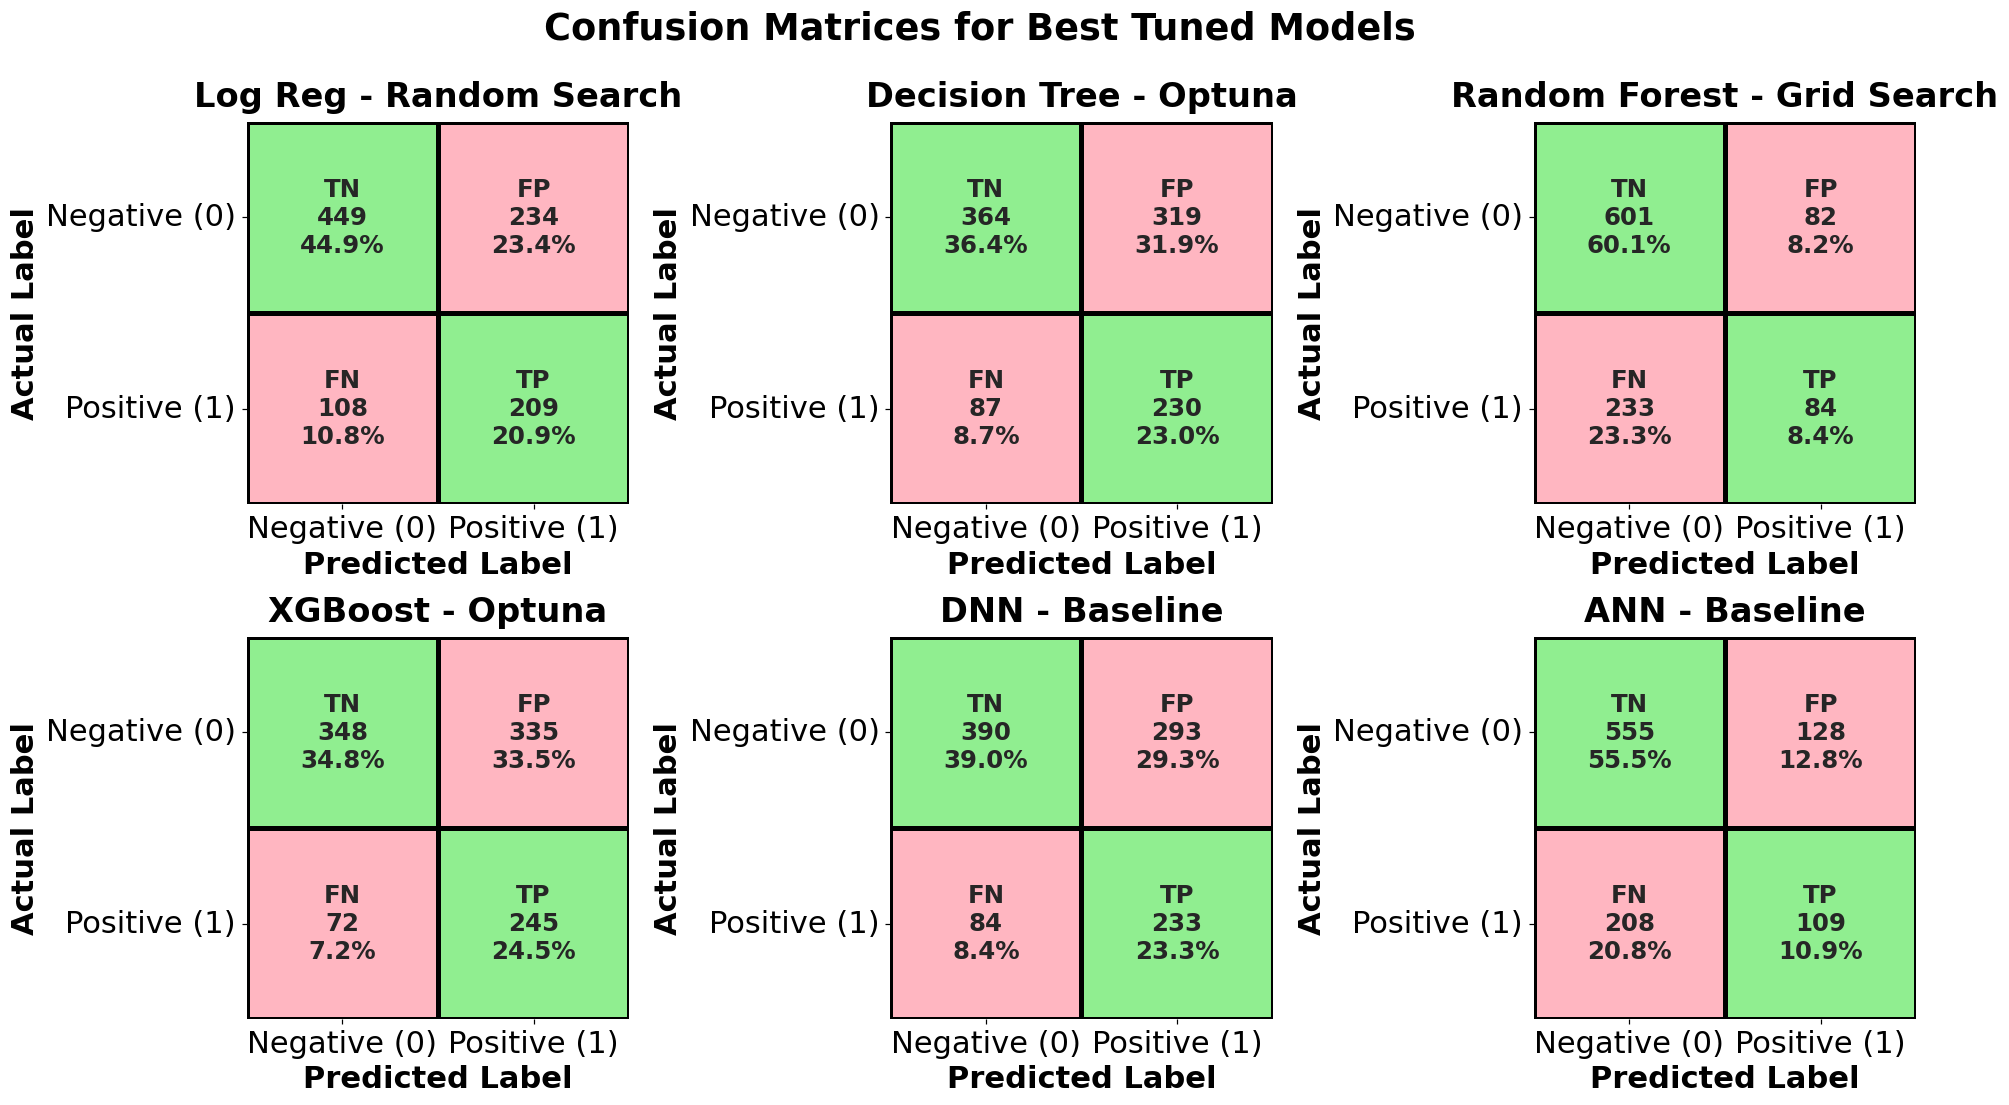


Confusion matrices generated successfully!
These matrices should now match the metrics in section 8.8.


In [84]:
"""
CORRECTED Section 8.10 — Confusion Matrices for All Models

This code generates confusion matrices that match the metrics in section 8.8.
The key fix is to use the ALREADY FITTED models that were evaluated to produce
the leaderboard metrics, rather than refitting them which can produce different results.

IMPORTANT ASSUMPTIONS:
1. The following variables exist from earlier sections:
   - fitted_ml_models: dict of fitted ML models from section 8.8
   - X_test, y_test: test data
   - build_ann(), build_dnn(): functions to build neural network architectures
   - fit_fold_preprocessors(), transform_with_preprocessors(): preprocessing functions
   - numeric_features, categorical_low, HIGH_CARD_COLS: feature lists
   
2. For DL models, we need to retrain them using the EXACT same procedure
   as in the baseline evaluation (same epochs, batch size, early stopping, etc.)
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

# ============================================================================
# STEP 1: GET PREDICTIONS FROM ALREADY-FITTED ML MODELS
# ============================================================================
# These models were already fitted in section 8.8 cell [74] and stored in 
# fitted_ml_models dictionary. We just need to get predictions from them.

ml_model_mapping = {
    'Log Reg - Random Search': 'LR_rand',
    'Decision Tree - Optuna': 'DT_optuna', 
    'Random Forest - Grid Search': 'RF_grid',
    'XGBoost - Optuna': 'XGB_optuna'
}

predictions = {}

print("Generating predictions from fitted ML models...")
for display_name, model_key in ml_model_mapping.items():
    if model_key in fitted_ml_models:
        print(f"  Getting predictions for {display_name}...")
        model = fitted_ml_models[model_key]
        # The LeakageSafeClassifier handles all preprocessing internally
        y_pred = model.predict(X_test)
        predictions[display_name] = y_pred
    else:
        print(f"  WARNING: {model_key} not found in fitted_ml_models")

# ============================================================================
# STEP 2: RETRAIN DL MODELS USING EXACT BASELINE PROCEDURE
# ============================================================================
# For DL models, we need to retrain them using the same exact procedure
# that was used in the baseline evaluation to get consistent results.

# Preprocess data for DL models
print("\nPreprocessing data for DL models...")
pre_global = fit_fold_preprocessors(
    X_train, y_train, 
    numeric_features, categorical_low, HIGH_CARD_COLS
)
X_train_mat, _ = transform_with_preprocessors(
    pre_global, X_train, 
    numeric_features, categorical_low, HIGH_CARD_COLS
)
X_test_mat, _ = transform_with_preprocessors(
    pre_global, X_test, 
    numeric_features, categorical_low, HIGH_CARD_COLS
)

# Calculate class weights
from sklearn.utils import class_weight
cw_vals = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = {0: cw_vals[0], 1: cw_vals[1]}

def train_dl_model_baseline(builder_func, name, epochs=100, batch_size=256, 
                            validation_split=0.2, patience=10):
    """
    Train a DL model using the exact same procedure as baseline evaluation.
    
    CRITICAL: This must match the training procedure used in section 7 
    to get consistent confusion matrix results.
    """
    print(f"  Training {name}...")
    from tensorflow.keras.callbacks import EarlyStopping
    
    model = builder_func(input_dim=X_train_mat.shape[1])
    
    # Early stopping callback (same as baseline)
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=0
    )
    
    # Train with same parameters as baseline
    model.fit(
        X_train_mat, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Get predictions
    y_prob = model.predict(X_test_mat, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    
    return y_pred

# Train DL models with baseline procedure
print("\nTraining DL models with baseline procedure...")
predictions['ANN - Baseline'] = train_dl_model_baseline(build_ann, 'ANN - Baseline')
predictions['DNN - Baseline'] = train_dl_model_baseline(build_dnn, 'DNN - Baseline')

# ============================================================================
# STEP 3: GENERATE CONFUSION MATRICES
# ============================================================================
print("\nGenerating confusion matrices...\n")

# Define the order of models to plot
model_list = [
    'Log Reg - Random Search', 
    'Decision Tree - Optuna', 
    'Random Forest - Grid Search',
    'XGBoost - Optuna', 
    'DNN - Baseline', 
    'ANN - Baseline'
]

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Custom colormap: Green for correct predictions (TN, TP), Pink for errors (FP, FN)
cmap_custom = ListedColormap(['#FFB6C1', '#90EE90'])  # Pink, Green

for i, model_name in enumerate(model_list):
    ax = axes[i]
    
    # Get predictions for this model
    if model_name not in predictions:
        ax.text(0.5, 0.5, f"{model_name}\nNo Predictions", 
                ha='center', va='center', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    y_pred = predictions[model_name]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate percentages
    total = np.sum(cm)
    cm_perc = cm / total * 100
    
    # Print metrics for verification
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{model_name}:")
    print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    # Create annotation labels with percentages
    labels = np.array([
        [f"TN\n{tn:,}\n{cm_perc[0,0]:.1f}%", f"FP\n{fp:,}\n{cm_perc[0,1]:.1f}%"],
        [f"FN\n{fn:,}\n{cm_perc[1,0]:.1f}%", f"TP\n{tp:,}\n{cm_perc[1,1]:.1f}%"]
    ])
    
    # Color grid: 1 for diagonal (correct), 0 for off-diagonal (errors)
    color_grid = np.array([[1, 0], [0, 1]])
    
    # Plot heatmap
    sns.heatmap(
        color_grid, 
        annot=labels, 
        fmt='', 
        cmap=cmap_custom,
        ax=ax, 
        cbar=False, 
        annot_kws={"size": 16, "weight": "bold"},
        linewidths=2, 
        linecolor='black',
        square=True
    )
    
    # Set title and labels
    ax.set_title(model_name, fontsize=22, fontweight='bold', pad=10)
    ax.set_xticklabels(['Negative (0)', 'Positive (1)'], fontsize=20)
    ax.set_yticklabels(['Negative (0)', 'Positive (1)'], fontsize=20, rotation=0)
    ax.set_xlabel("Predicted Label", fontsize=20, fontweight='bold')
    ax.set_ylabel("Actual Label", fontsize=20, fontweight='bold')

plt.suptitle('Confusion Matrices for Best Tuned Models', 
             fontsize=24, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Confusion matrices generated successfully!")
print("These matrices should now match the metrics in section 8.8.")
print("="*70)

## 9. Model Interpretability with SHAP


=== SHAP explainability for LogReg ===


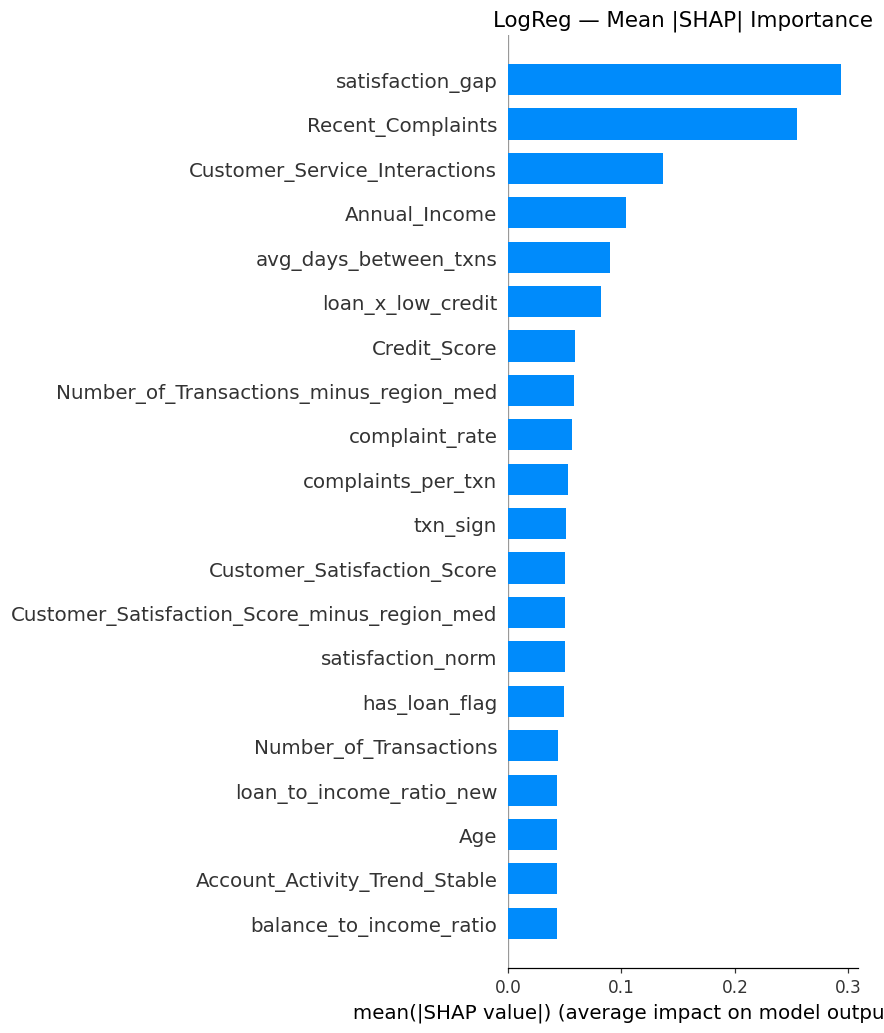

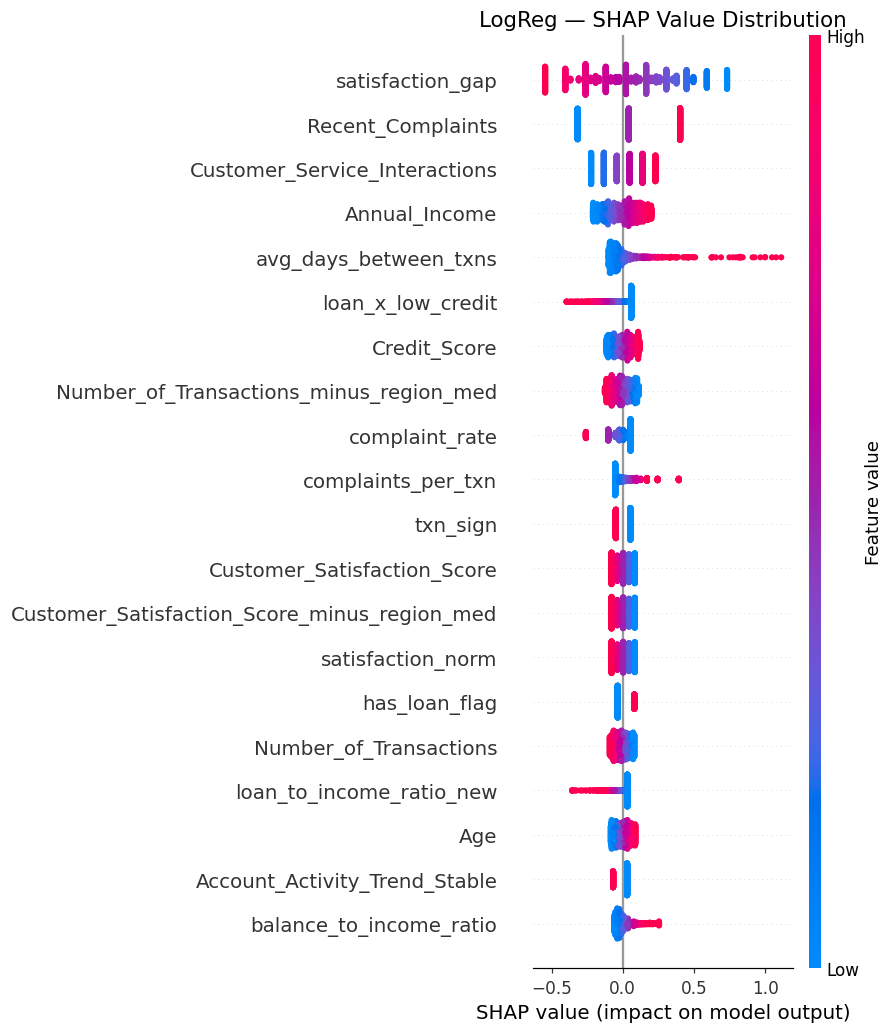


✅ SHAP analysis complete. You now have global and per-feature interpretability.


In [79]:
# === 9. Model Interpretability with SHAP ===
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sample subset for speed (SHAP can be heavy)
X_sample = X_train.sample(min(1000, len(X_train)), random_state=42)
y_sample = y_train.loc[X_sample.index]

# --- This section (re-defining models) is correct ---
# build fitted versions of tuned models (same params from Optuna best studies)
lr_params, lr_overs = optuna_results_f1["LR"].best_params.copy(), optuna_results_f1["LR"].best_params.get("oversampling","none")
# rf_params, rf_overs = optuna_results_f1["RF"].best_params.copy(), optuna_results_f1["RF"].best_params.get("oversampling","none")
# xgb_params, xgb_overs = optuna_results_f1["XGB"].best_params.copy(), optuna_results_f1["XGB"].best_params.get("oversampling","none")

# prepare leakage-safe wrappers
models_to_explain = {
    "LogReg": LeakageSafeClassifier(
        base_estimator=LogisticRegression(**{k:v for k,v in lr_params.items() if k!="oversampling"}),
        numeric_features=numeric_features,
        categorical_low=categorical_low,
        high_card_cols=HIGH_CARD_COLS,
        oversampling=lr_overs,
        random_state=42
    )
    # ,
    # "RandomForest": ... (your other models)
    # "XGBoost": ... (your other models)
}

shap_results = {}
for name, model in models_to_explain.items():
    print(f"\n=== SHAP explainability for {name} ===")
    model.fit(X_sample, y_sample)
    
    # --- FIX 1: Access the preprocessor using model._pre_ ---
    X_enc, feat_names = transform_with_preprocessors(
        model._pre_,  # <-- Use _pre_ (with underscores)
        X_sample, 
        numeric_features, 
        categorical_low, 
        HIGH_CARD_COLS
    )
    
    # Create a DataFrame for SHAP (important for feature names)
    X_enc_df = pd.DataFrame(X_enc, columns=feat_names, index=X_sample.index)

    if hasattr(model, "_est_") and hasattr(model._est_, "predict_proba"):
        
        # --- FIX 2: Access the *fitted* estimator using model._est_ ---
        explainer = (
            shap.TreeExplainer(model._est_) if name in ["RandomForest","XGBoost"]
            # Pass the fitted estimator (_est_) and the *DataFrame* X_enc_df
            else shap.LinearExplainer(model._est_, X_enc_df) 
        )
        
        # Pass the DataFrame to shap_values
        shap_values = explainer.shap_values(X_enc_df)
        
        shap_results[name] = shap_values

        # summary plot (global importance)
        plt.title(f"{name} — Mean |SHAP| Importance")
        # Pass the DataFrame for correct labels
        shap.summary_plot(shap_values, X_enc_df, plot_type="bar", show=True)
        plt.show()

        # top detailed plot
        plt.title(f"{name} — SHAP Value Distribution")
        shap.summary_plot(shap_values, X_enc_df, show=True)
        plt.show() # Add show() for the summary plot as well

print("\n✅ SHAP analysis complete. You now have global and per-feature interpretability.")

## 10. Monte carlo simulation

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. EXTRACT CV COUNTS
# Now using the robust cross-validated predictions generated above
y_true_lr, y_pred_lr = cv_predictions['Log Reg - Random Search']
y_true_dnn, y_pred_dnn = cv_predictions['DNN - Baseline']

lr_tn, lr_fp, lr_fn, lr_tp = confusion_matrix(y_true_lr, y_pred_lr).ravel()
dnn_tn, dnn_fp, dnn_fn, dnn_tp = confusion_matrix(y_true_dnn, y_pred_dnn).ravel()

# 2. MONTE CARLO SIMULATION
n_simulations = 10000
np.random.seed(42)

# Beta Distributions for Rates (Recall & FPR)
# We add 1 to counts for non-informative prior
lr_recall_dist = np.random.beta(lr_tp + 1, lr_fn + 1, n_simulations)
lr_fpr_dist    = np.random.beta(lr_fp + 1, lr_tn + 1, n_simulations)

dnn_recall_dist = np.random.beta(dnn_tp + 1, dnn_fn + 1, n_simulations)
dnn_fpr_dist    = np.random.beta(dnn_fp + 1, dnn_tn + 1, n_simulations)

# Scenario Assumptions
N_customers = 100000
prevalence = np.mean(y_true_lr) # Use actual training prevalence
N_pos = int(N_customers * prevalence)
N_neg = int(N_customers * (1 - prevalence))

# Calculate Differences (DNN - LR)
delta_tp = N_pos * (dnn_recall_dist - lr_recall_dist)
delta_fp = N_neg * (dnn_fpr_dist - lr_fpr_dist)
delta_targeted = delta_tp + delta_fp

# Break-Even Ratio = Delta TP / Delta Targeted
# (Profit_Diff = CLV * dTP - Cost * dTargeted => 0 => Cost/CLV = dTP/dTargeted)
break_even_ratios = delta_tp / delta_targeted

# Filter valid (where DNN actually targets more)
break_even_ratios = break_even_ratios[delta_targeted > 0]

# 3. PLOT
plt.figure(figsize=(10, 6))
sns.histplot(break_even_ratios, kde=True, color='purple', bins=50, alpha=0.6)

mean_ratio = np.mean(break_even_ratios)
p05 = np.percentile(break_even_ratios, 5)
p95 = np.percentile(break_even_ratios, 95)

plt.axvline(mean_ratio, color='k', linestyle='--', label=f'Mean Ratio: {mean_ratio:.3f}')
plt.axvline(p05, color='r', linestyle=':', label=f'90% CI: {p05:.3f} - {p95:.3f}')
plt.axvline(p95, color='r', linestyle=':')

plt.title('Monte Carlo: Break-Even (Cost / CLV) Ratio\n(Using Cross-Validated Performance)', fontsize=14)
plt.xlabel('Retention Cost / CLV Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean Break-Even Ratio: {mean_ratio:.4f}")

NameError: name 'cv_predictions' is not defined